# Here we're going to take Final Fantasy MIDIs and convert them to 2D images with multiple channels
- the x information will be the offset of the note
- the y information will be the pitch of the note
- the channels will stack multiple 'measures' consecutively, so you have longer time domain info considered
- since we'll be training a GAN we don't need validation info

In [235]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.utils import np_utils
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation
from tensorflow.keras.models import Sequential
import math

from music21 import converter, instrument, note, chord, stream
import glob

from keras.utils import np_utils
import os

FONTSIZE=18
plt.rcParams['figure.figsize']=(15,8)
plt.rcParams['font.size']=FONTSIZE

# First let's rename all of our Final Fantasy MIDIs to get rid of annoying spaces

In [133]:
filenames=glob.glob('../MIDI_files/F/F/Final Fantasy*.mid')

for i in filenames:
    fbase=i[18:]
    fnew=fbase.replace(" ","")
    
    command='cp "'+str(i)+'" ../Final_Fantasy/'+fnew
    print(command)
    os.system(command)

cp "../MIDI_files/F/F/Final Fantasy VI - The Decisive Battle.mid" ../Final_Fantasy/FinalFantasyVI-TheDecisiveBattle.mid
cp "../MIDI_files/F/F/Final Fantasy V - The Last Battle.mid" ../Final_Fantasy/FinalFantasyV-TheLastBattle.mid
cp "../MIDI_files/F/F/Final Fantasy III - Ancients Village.mid" ../Final_Fantasy/FinalFantasyIII-AncientsVillage.mid
cp "../MIDI_files/F/F/Final Fantasy IX - Kujas Theme.mid" ../Final_Fantasy/FinalFantasyIX-KujasTheme.mid
cp "../MIDI_files/F/F/Final Fantasy X - Suteki Da Ne.mid" ../Final_Fantasy/FinalFantasyX-SutekiDaNe.mid
cp "../MIDI_files/F/F/Final Fantasy VII - Fighting.mid" ../Final_Fantasy/FinalFantasyVII-Fighting.mid
cp "../MIDI_files/F/F/Final Fantasy VII - Descandant of the Shinobi.mid" ../Final_Fantasy/FinalFantasyVII-DescandantoftheShinobi.mid
cp "../MIDI_files/F/F/Final Fantasy X-2 - 1000 Words.mid" ../Final_Fantasy/FinalFantasyX-2-1000Words.mid
cp "../MIDI_files/F/F/Final Fantasy I - Main Theme.mid" ../Final_Fantasy/FinalFantasyI-MainTheme.mid
cp 

# Visualize the MIDI information

In [174]:
filename='../Final_Fantasy/FinalFantasyCrystalChronicles-AnnualFestival.mid'
midi=converter.parse(filename)
s2=instrument.partitionByInstrument(midi)

pitches=[]
offsets=[]
durations=[]

for part in s2.parts:
    if 'Piano' in str(part):
        notes_to_parse=part.recurse()
        for element in notes_to_parse:
            
            if isinstance(element,note.Note):
                offsets.append(element.offset)
                pitches.append(element.nameWithOctave)
                durations.append(element.duration.quarterLength)

            elif isinstance(element,chord.Chord):
                
                for pitch in element.pitches:
                    offsets.append(element.offset)
                    pitches.append(pitch.nameWithOctave)
                    durations.append(element.duration.quarterLength)
                    
                    
                
print(max(offsets))
print(len(offsets))
print(len(pitches))
print(len(durations))

244.0
983
983
983


In [175]:
print(set(durations))

{0.5, 1.5, 0.0, 0.25, 1.0, 4.0, 2.0, 7.0, 6.0, Fraction(1, 3)}


In [176]:

print(float(durations[119]))

0.3333333333333333


In [177]:
print(set(pitches))

{'E-4', 'C2', 'A5', 'E3', 'A4', 'G5', 'A3', 'B-2', 'C#3', 'G2', 'C5', 'G3', 'E-3', 'B4', 'G4', 'F#3', 'B3', 'F#5', 'C#5', 'D5', 'E-5', 'D2', 'C#4', 'D4', 'E4', 'F#4', 'A2', 'B2', 'C4', 'D3', 'E5', 'B-3', 'C3'}


# Create a dictionary that maps all pitches to ints, keeping their order

In [178]:
#this will have key=pitch value=integer

pitch_dict={}

min_octave=-5
num_octaves=11

notes=['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict[pitch]=int(count)
        
print(pitch_sort['B3'])
num_pitches=count+1
print(num_pitches)
    

98
132


# Fill out grid locations

In [179]:
pixel_length=float(1/12) #this is divisible by both 1/3 and 1/4


grid_all=np.zeros((num_pitches,int(max(offsets)/pixel_length)))

for i in range(len(offsets)):
    
    
    offset_temp=offsets[i]
    pitch_temp=pitches[i]
    duration_temp=durations[i]


    #find column grid value
    column_start_idx=int(offset_temp/pixel_length-1)
    column_end_idx=int(column_start_idx+duration_temp/pixel_length)

    #find row grid value
    row_idx=int(pitch_dict[pitch_temp])

    grid_all[row_idx,column_start_idx:column_end_idx]=1

In [180]:
print(grid_all.shape)

(132, 2928)


(-10.0, 10.0, -1.0, 1.0)

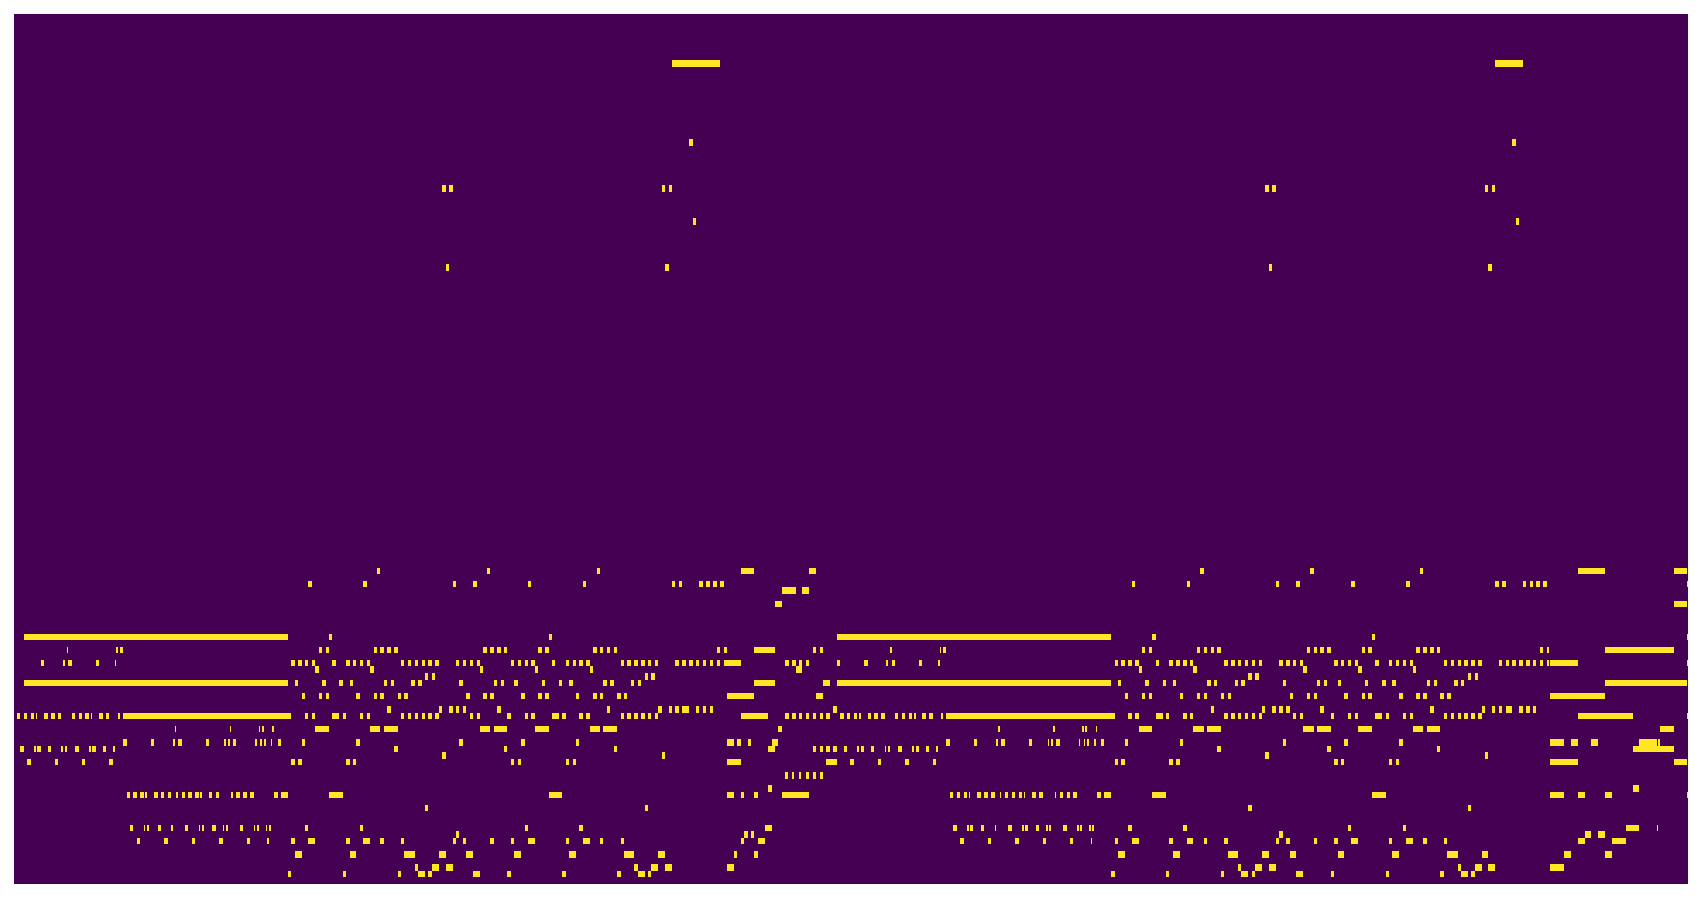

In [181]:

#plt.axis([0,grid_all.shape[1],0,grid_all.shape[0]])
plt.imshow(grid_all,extent=[-10,10,-1,1],aspect='auto')
plt.axis('off')

# Ok now that we know this works for one song let's do it for every song

at the end of the day we'll have a list where each element is our 2D grid for a given song

In [195]:
# Let's figure out our whole range of notes

filenames=glob.glob('../Final_Fantasy/FinalFantasy*.mid')

pitches=[]
offsets=[]
durations=[]

skip_song_idx=[]
count=-1
for i in filenames:
    count+=1
    try:
    
        filename=i
        midi=converter.parse(filename)
        s2=instrument.partitionByInstrument(midi)

        for part in s2.parts:
            if 'Piano' in str(part):
                notes_to_parse=part.recurse()
                for element in notes_to_parse:

                    if isinstance(element,note.Note):
                        offsets.append(element.offset)
                        pitches.append(element.nameWithOctave)
                        durations.append(element.duration.quarterLength)

                    elif isinstance(element,chord.Chord):

                        for pitch in element.pitches:
                            offsets.append(element.offset)
                            pitches.append(pitch.nameWithOctave)
                            durations.append(element.duration.quarterLength)
                                
    except:
        skip_song_idx.append(count)
        
idx_all=np.arange(len(filenames))
idx_keep=np.delete(idx_all,skip_song_idx)
                
print(max(offsets))
print(len(offsets))
print(len(pitches))
print(len(durations))

2607.0
136959
136959
136959


In [196]:
print(len(idx_keep))
print(len(skip_song_idx))

187
5


In [197]:
print(set(pitches))

{'G7', 'G#1', 'F#6', 'A3', 'B-2', 'C#7', 'B4', 'G#3', 'G#6', 'B3', 'C#5', 'F2', 'E-5', 'F#1', 'C1', 'F3', 'F5', 'E1', 'G#5', 'C#6', 'E5', 'C2', 'E3', 'B-4', 'F6', 'C5', 'B0', 'G4', 'F#3', 'F#5', 'B5', 'D6', 'E4', 'B2', 'C4', 'B-3', 'C3', 'E-4', 'A5', 'A4', 'E-2', 'A1', 'G#2', 'F4', 'C#3', 'B-1', 'E-3', 'B-5', 'C6', 'C7', 'C#2', 'B1', 'E7', 'D2', 'C#4', 'E6', 'F#4', 'F1', 'E-1', 'A6', 'B6', 'E-6', 'G5', 'G6', 'F#2', 'B-6', 'G1', 'G2', 'G3', 'G#4', 'D5', 'D1', 'D4', 'E2', 'D7', 'A2', 'D3'}


In [213]:
lengths=[len(i) for i in pitches]
print(set(lengths))

{2, 3}


In [198]:
print(set(durations))

{0.5, 1.0, 0.0, 3.0, 3.75, 4.0, 4.5, 1.75, 2.5, 1.5, 0.25, 0.75, 2.0, 2.25, 1.25, 6.0, 3.5, 8.0, 2.75, 10.0, 12.0, 4.75, 4.25, 3.25, 15.0, 16.0, 5.0, 5.75, 5.5, 6.75, 6.25, 6.5, 7.0, 7.75, 7.25, 7.5, 40.0, Fraction(2, 3), Fraction(5, 3), Fraction(8, 3), Fraction(11, 3), 9.0, 9.5, 9.75, 10.5, 11.75, 11.5, 11.25, 11.0, 12.25, Fraction(1, 3), Fraction(4, 3), Fraction(7, 3), Fraction(10, 3), Fraction(13, 3), Fraction(22, 3)}


In [199]:
print(max(offsets))

2607.0


In [200]:
# make a dictionary that maps notes to ints

#this will have key=pitch value=integer

pitch_dict={}

min_octave=-6
num_octaves=14

notes=['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict[pitch]=int(count)
        
num_pitches=count+1
print(num_pitches)

168


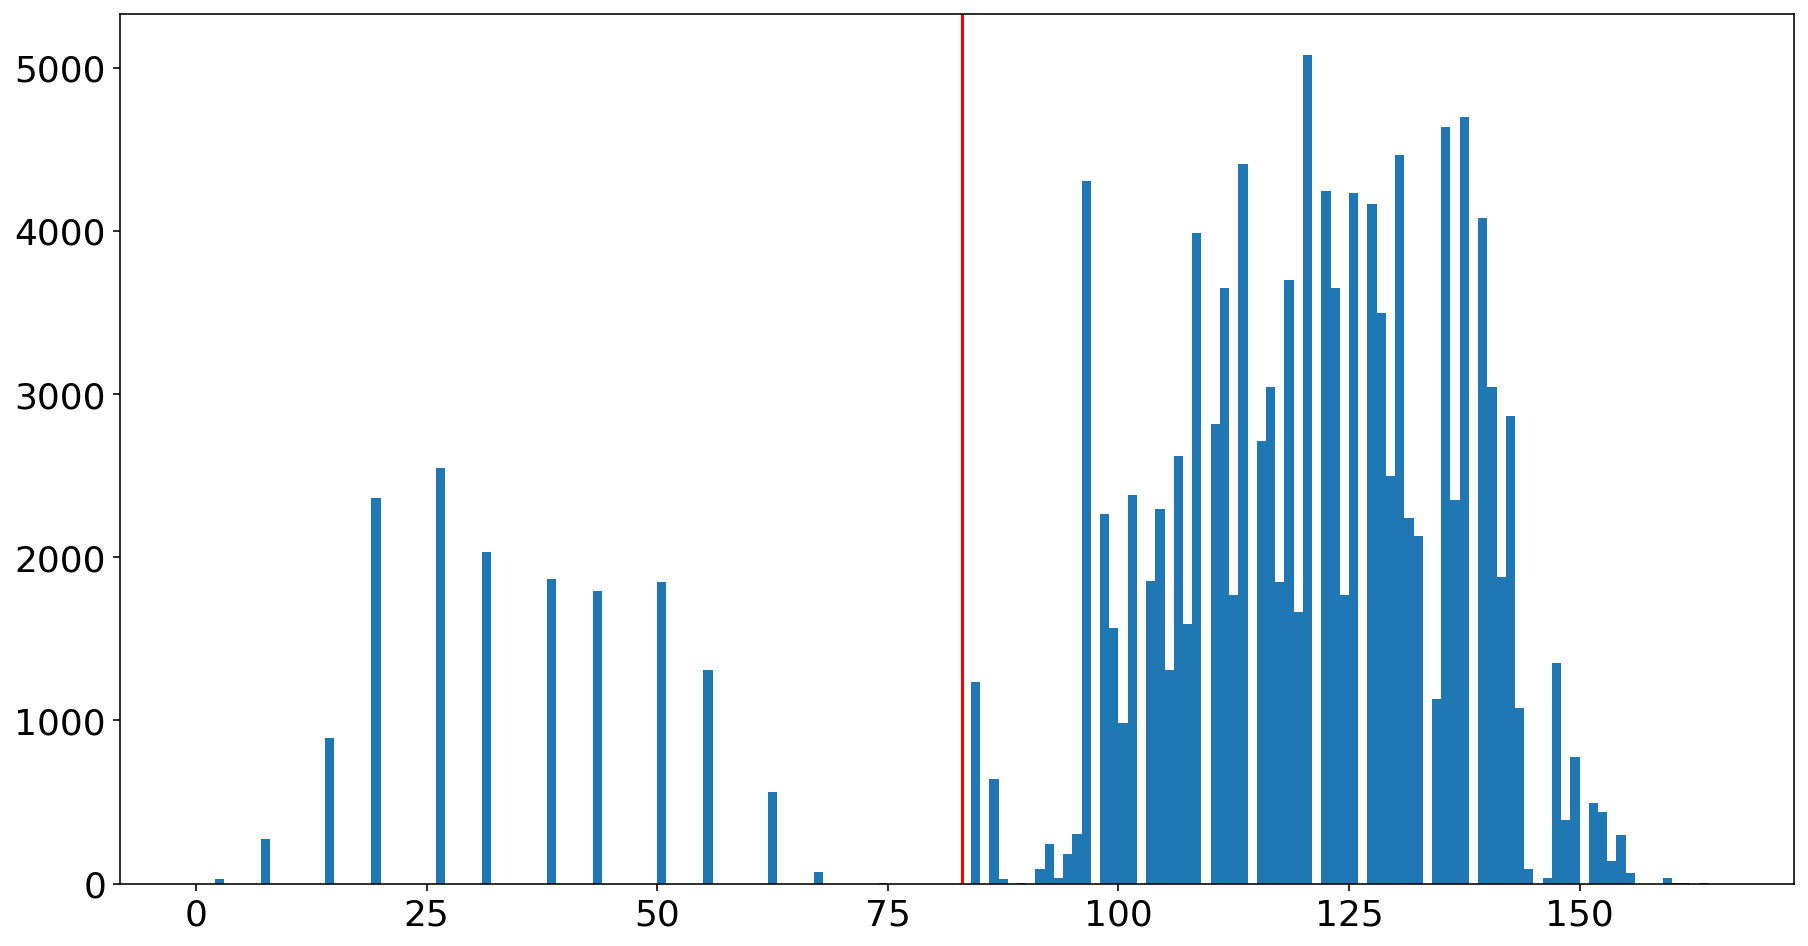

In [210]:
#let's see how often each note shows up
ints=[]

pitch_test='G#0'
int_test=pitch_dict[pitch_test]

for i in pitches:    
    ints.append(pitch_dict[i])
    
bins=np.arange(0,max(ints))
ignored,ignored,ignored=plt.hist(ints,bins=bins)
plt.axvline(int_test,c='r')
    
    

# We could make our images significantly smaller by removing everything below A1

In [211]:
# make a dictionary that maps notes to ints

#this will have key=pitch value=integer

pitch_dict={}

min_octave=1
num_octaves=7

notes=['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict[pitch]=int(count)
        
num_pitches=count+1
print(num_pitches)

84


In [217]:
def check_pitch(pitch):
    if len(pitch)==2:
        octave=int(pitch[-1])
    if len(pitch)==3:
        if '#' in pitch:
            octave=int(pitch[-1])
        if '-' in pitch:
            octave=int(pitch[1:])
        
    if octave>=1:
        return True
    else:
        return False

In [304]:
pixel_length=float(1/12) 
grid_out=[]

measures_per_image=1
image_width=int(4*measures_per_image/pixel_length)
image_height=int(num_pitches)
num_channels=int(4)


for i in range(len(filenames)):
    filename=filenames[i]
    if i in idx_keep:
        
        #populate pitches, durations, and offsets
        midi=converter.parse(filename)
        s2=instrument.partitionByInstrument(midi)
        pitches=[]
        offsets=[]
        durations=[]

        for part in s2.parts:
            if 'Piano' in str(part):
                notes_to_parse=part.recurse()
                for element in notes_to_parse:

                    if isinstance(element,note.Note):
                        #only keep if pitch is in octave 1 or greater
                        if check_pitch(element.nameWithOctave):
                            offsets.append(element.offset)
                            pitches.append(element.nameWithOctave)
                            durations.append(element.duration.quarterLength)

                    elif isinstance(element,chord.Chord):

                        for pitch in element.pitches:
                            #only keep if pitch is in octave 1 or greater
                            if check_pitch(pitch.nameWithOctave):
                                offsets.append(element.offset)
                                pitches.append(pitch.nameWithOctave)
                                durations.append(element.duration.quarterLength)
        #print(pitches)

        if len(offsets)>0:
                                
            if max(offsets)>num_channels*measures_per_image*4:
                #the song is long enough

                #create grid
                grid_temp=np.zeros((num_pitches,int(max(offsets)/pixel_length)))

                for j in range(len(offsets)):


                    offset_temp=offsets[j]
                    pitch_temp=pitches[j]
                    duration_temp=durations[j]
                    



                    #find column grid value
                    column_start_idx=int(offset_temp/pixel_length)
                    delta=duration_temp/pixel_length
                    column_end_idx=int(column_start_idx+delta)

                    #find row grid value
                    row_idx=int(pitch_dict[pitch_temp])

                    grid_temp[row_idx,column_start_idx:column_end_idx]=1



                grid_out.append(grid_temp)
        

In [305]:
print(len(grid_out))
print(len(idx_keep))

162
187


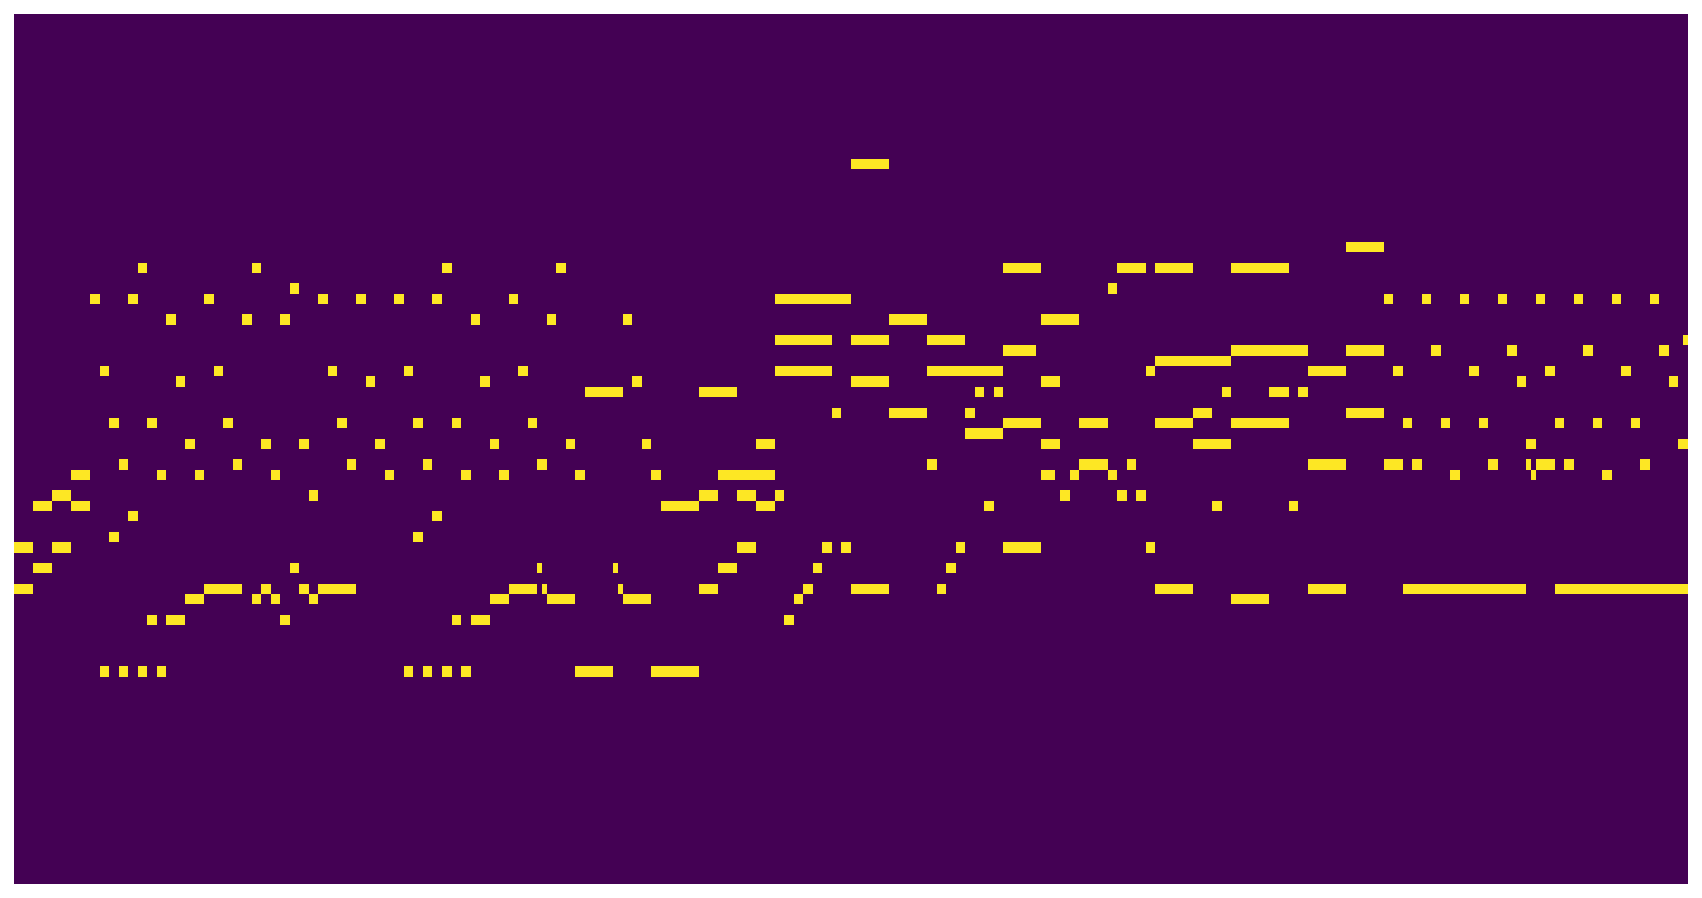

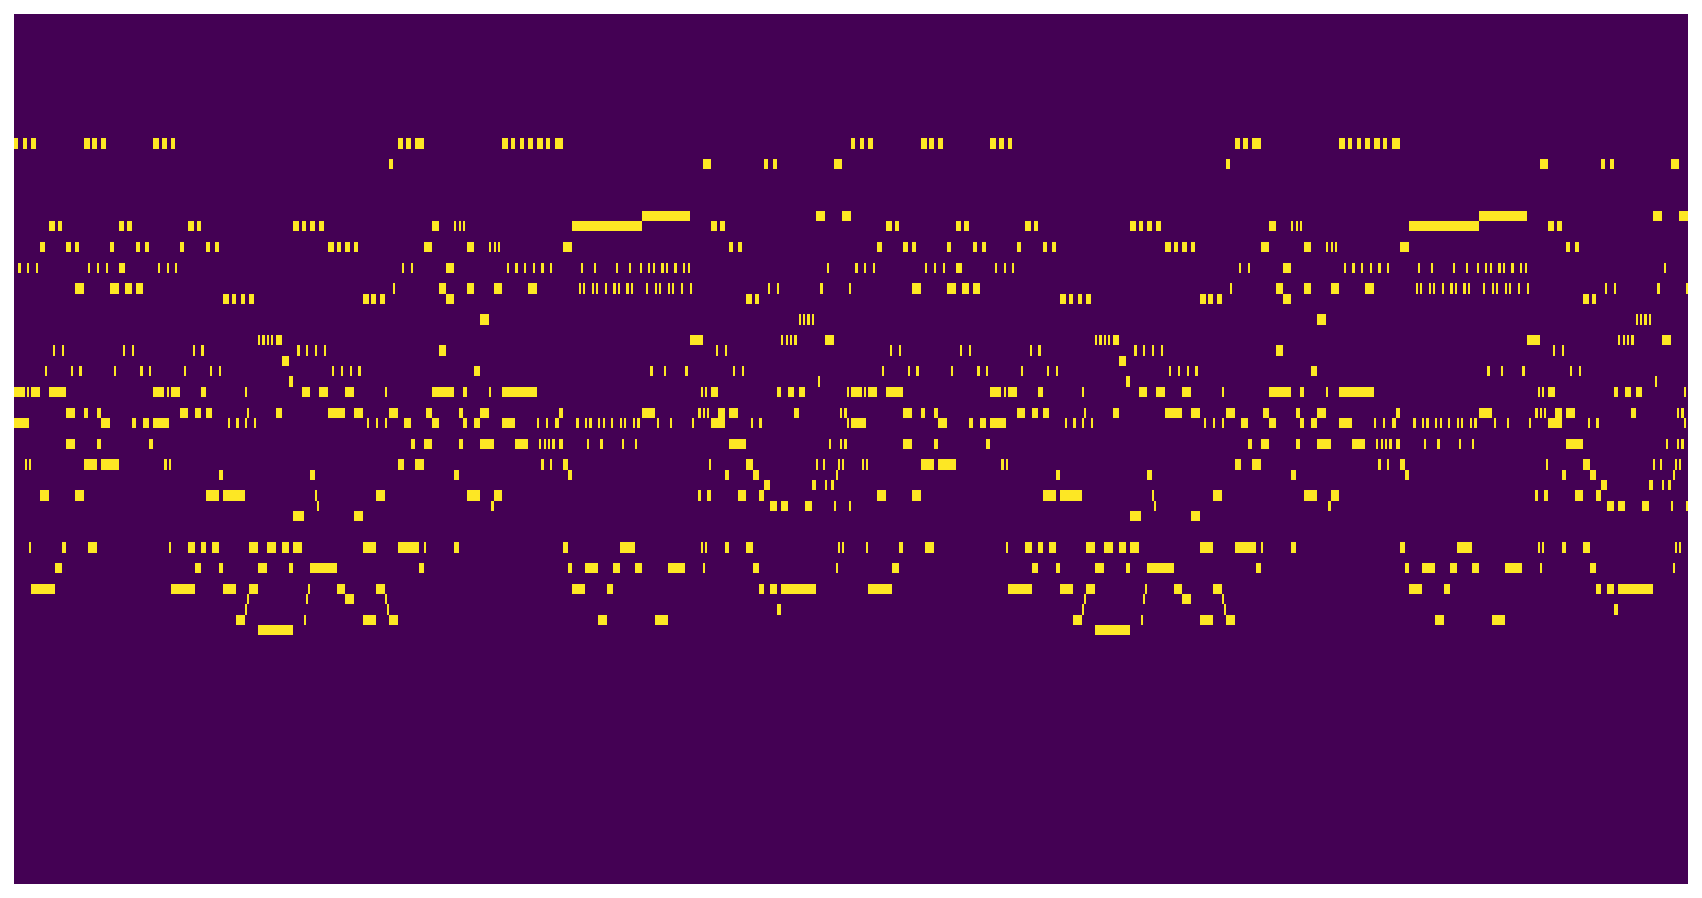

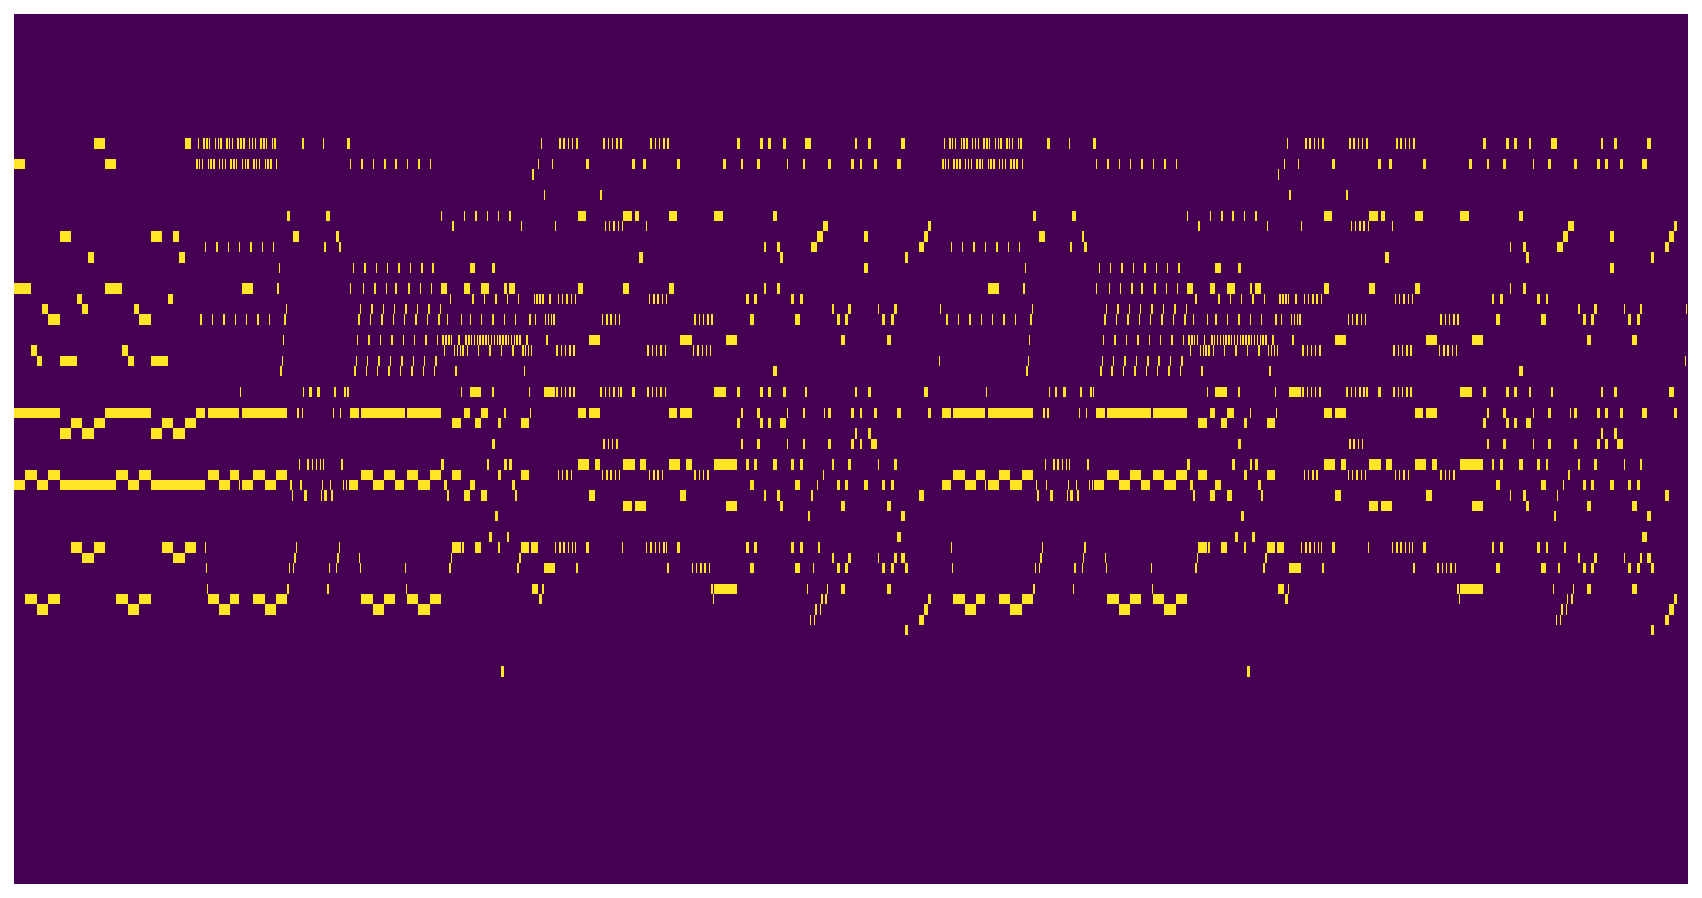

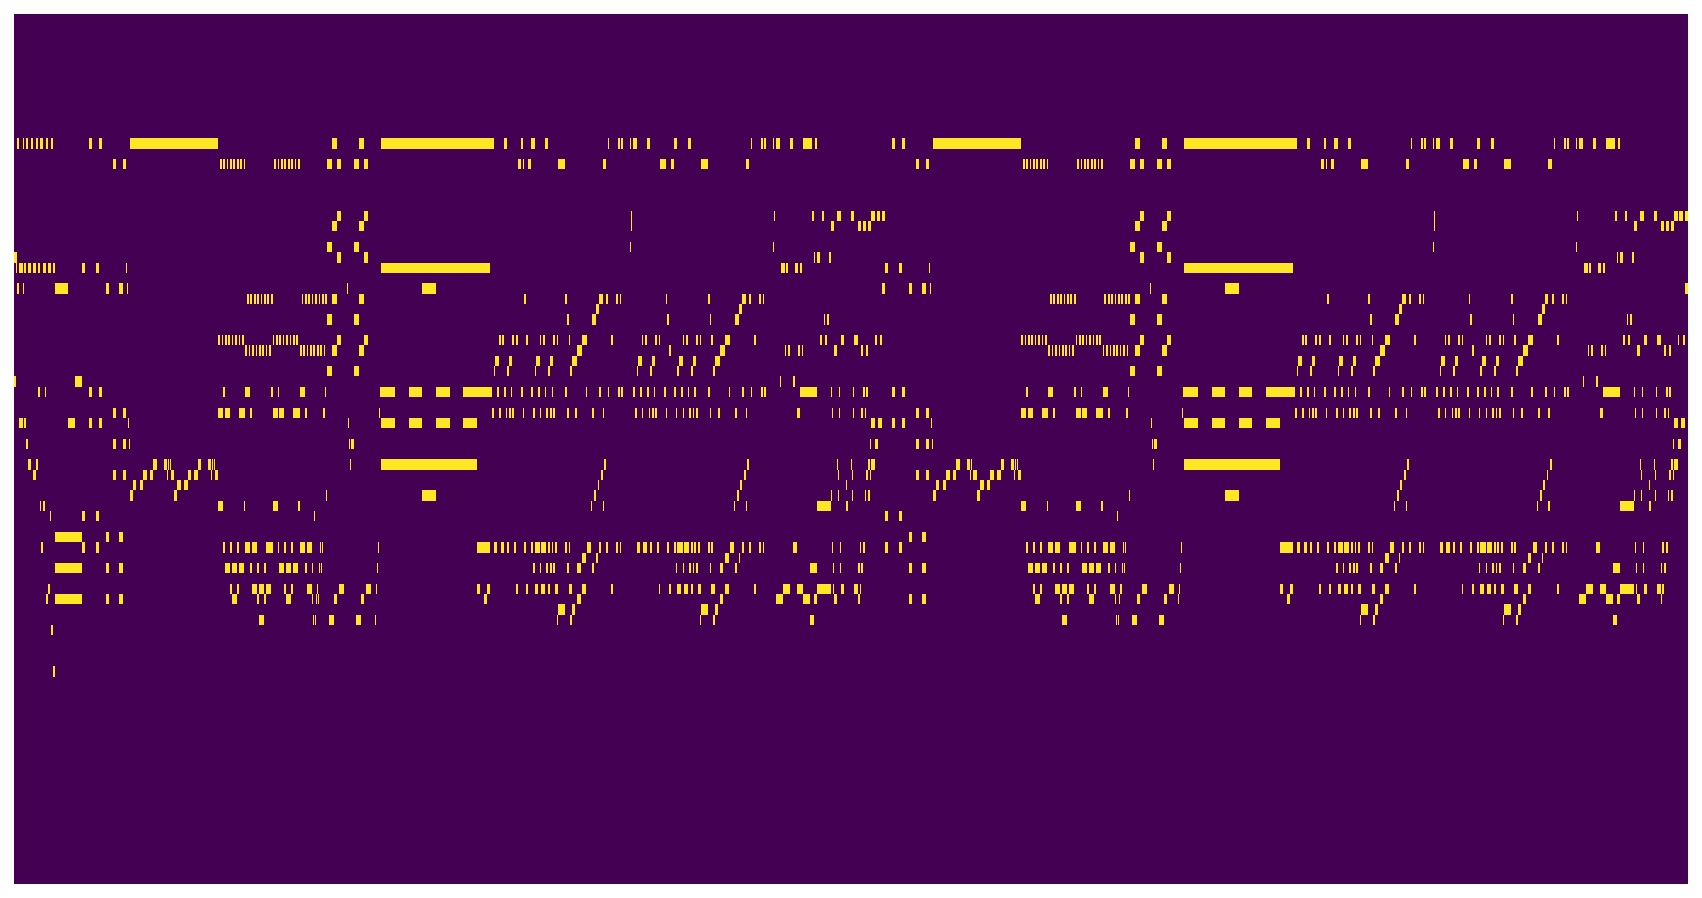

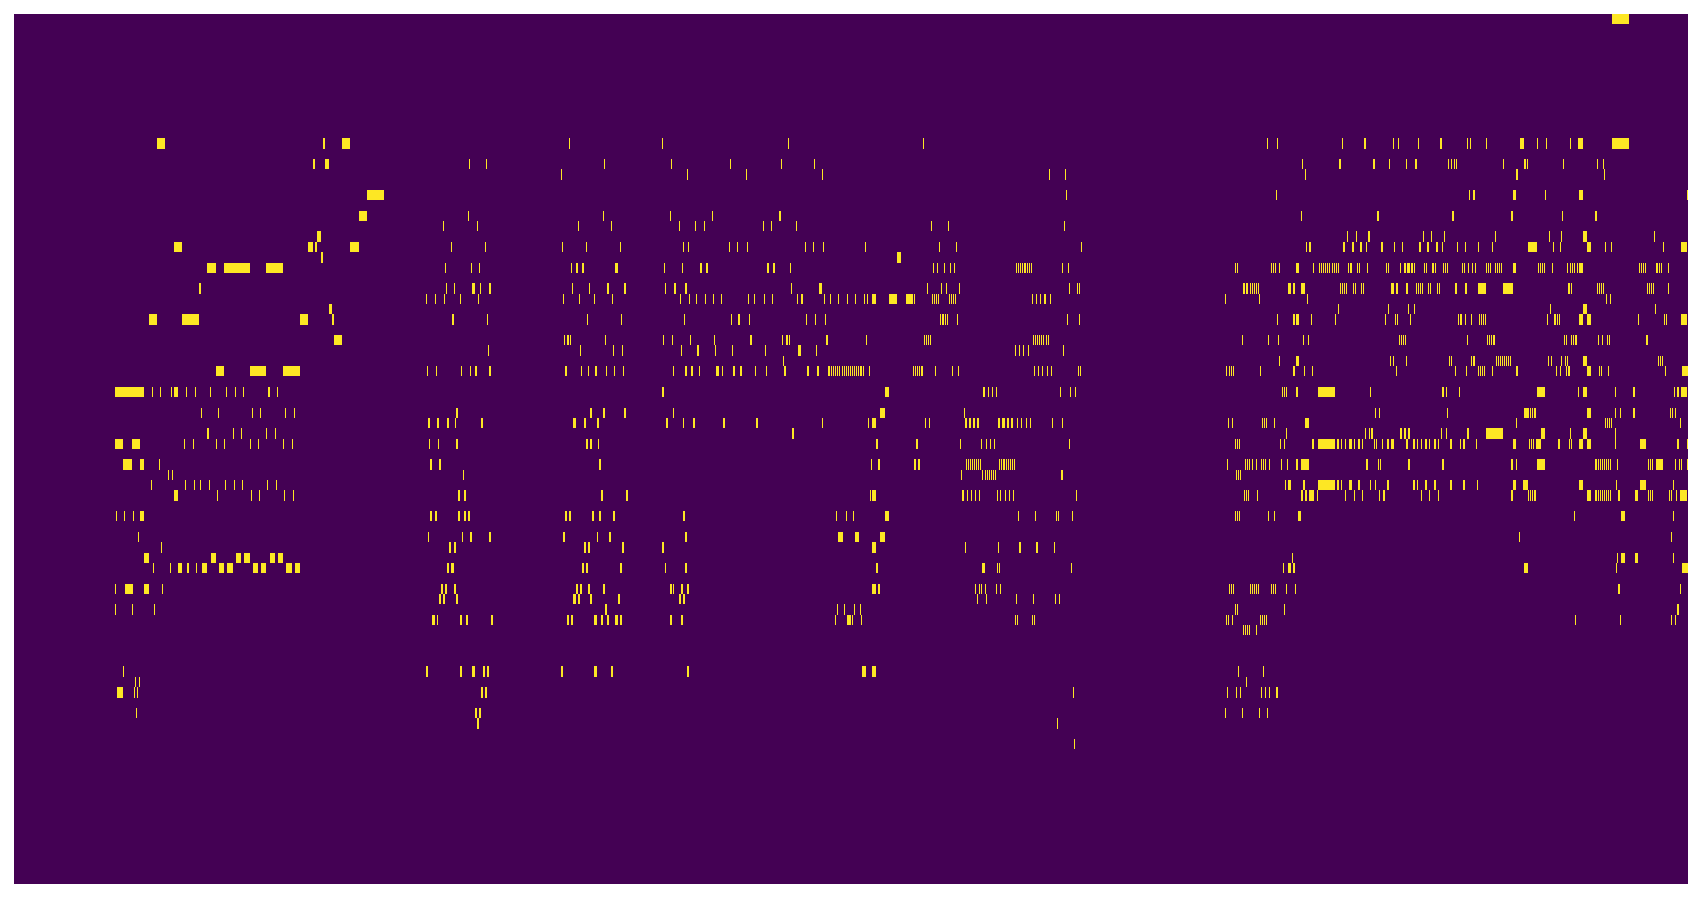

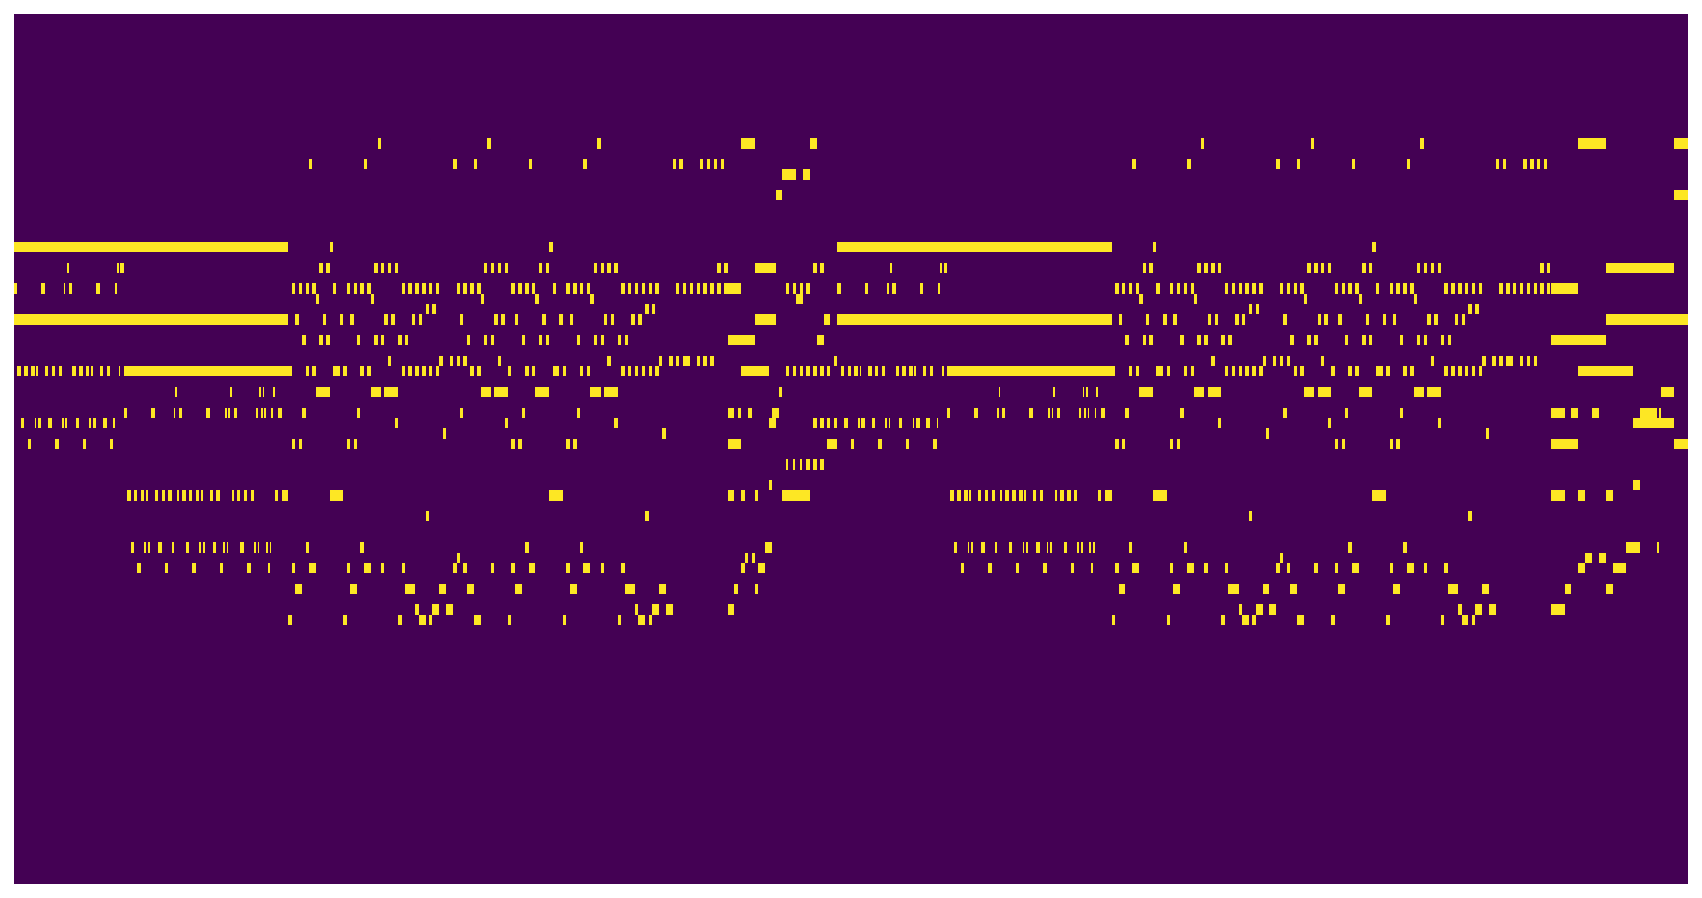

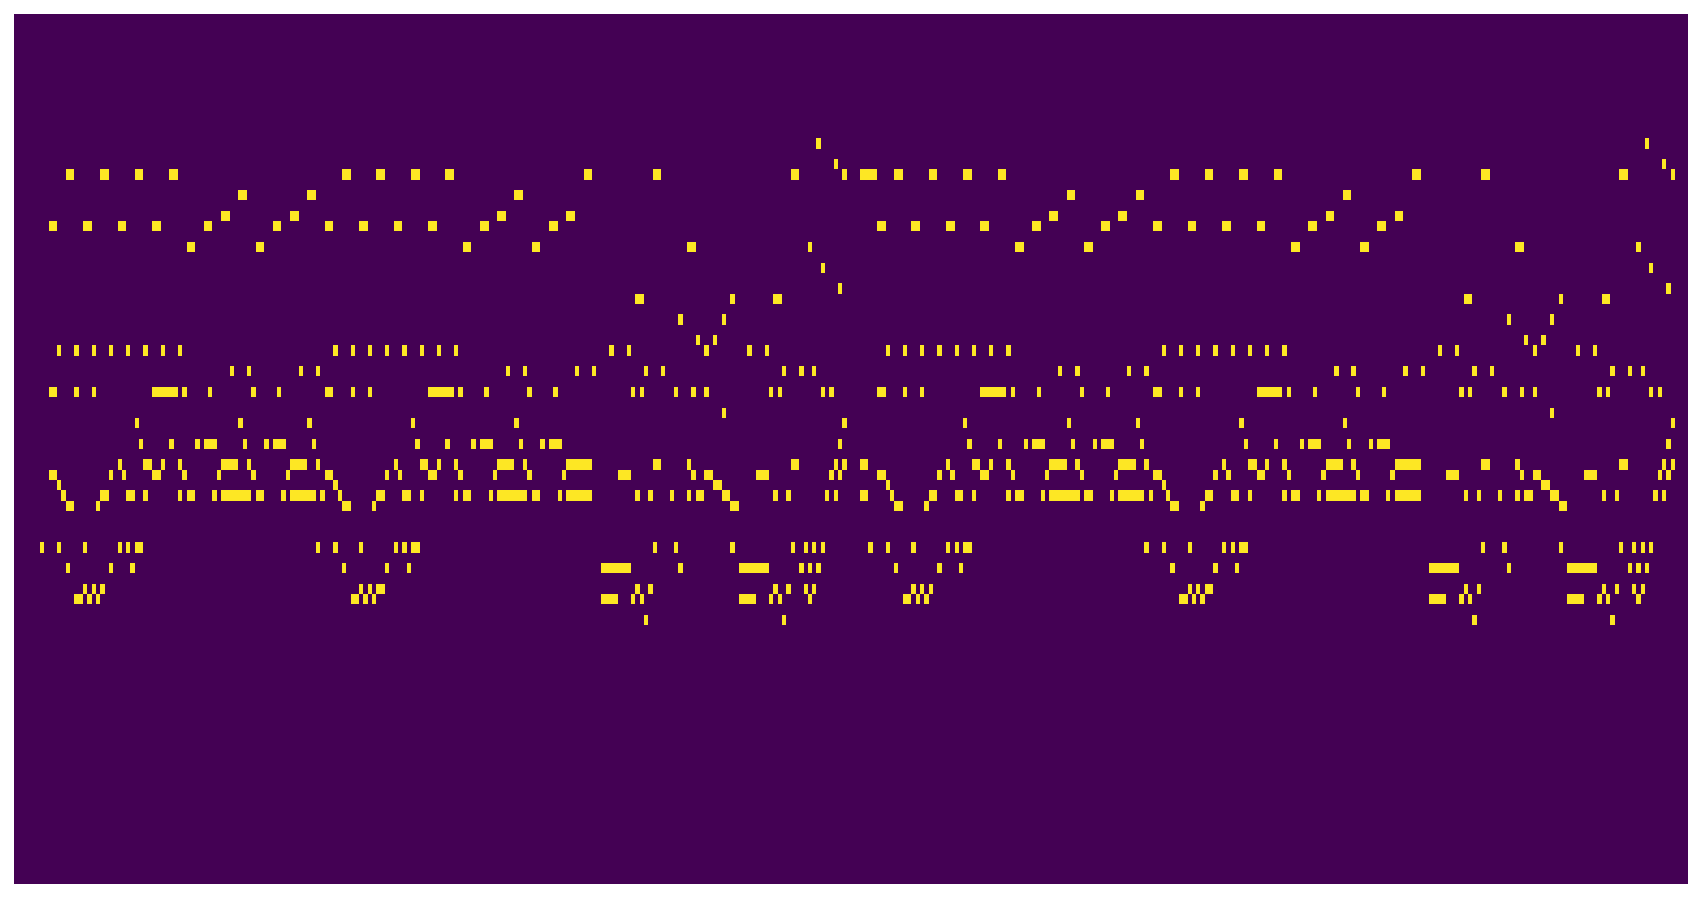

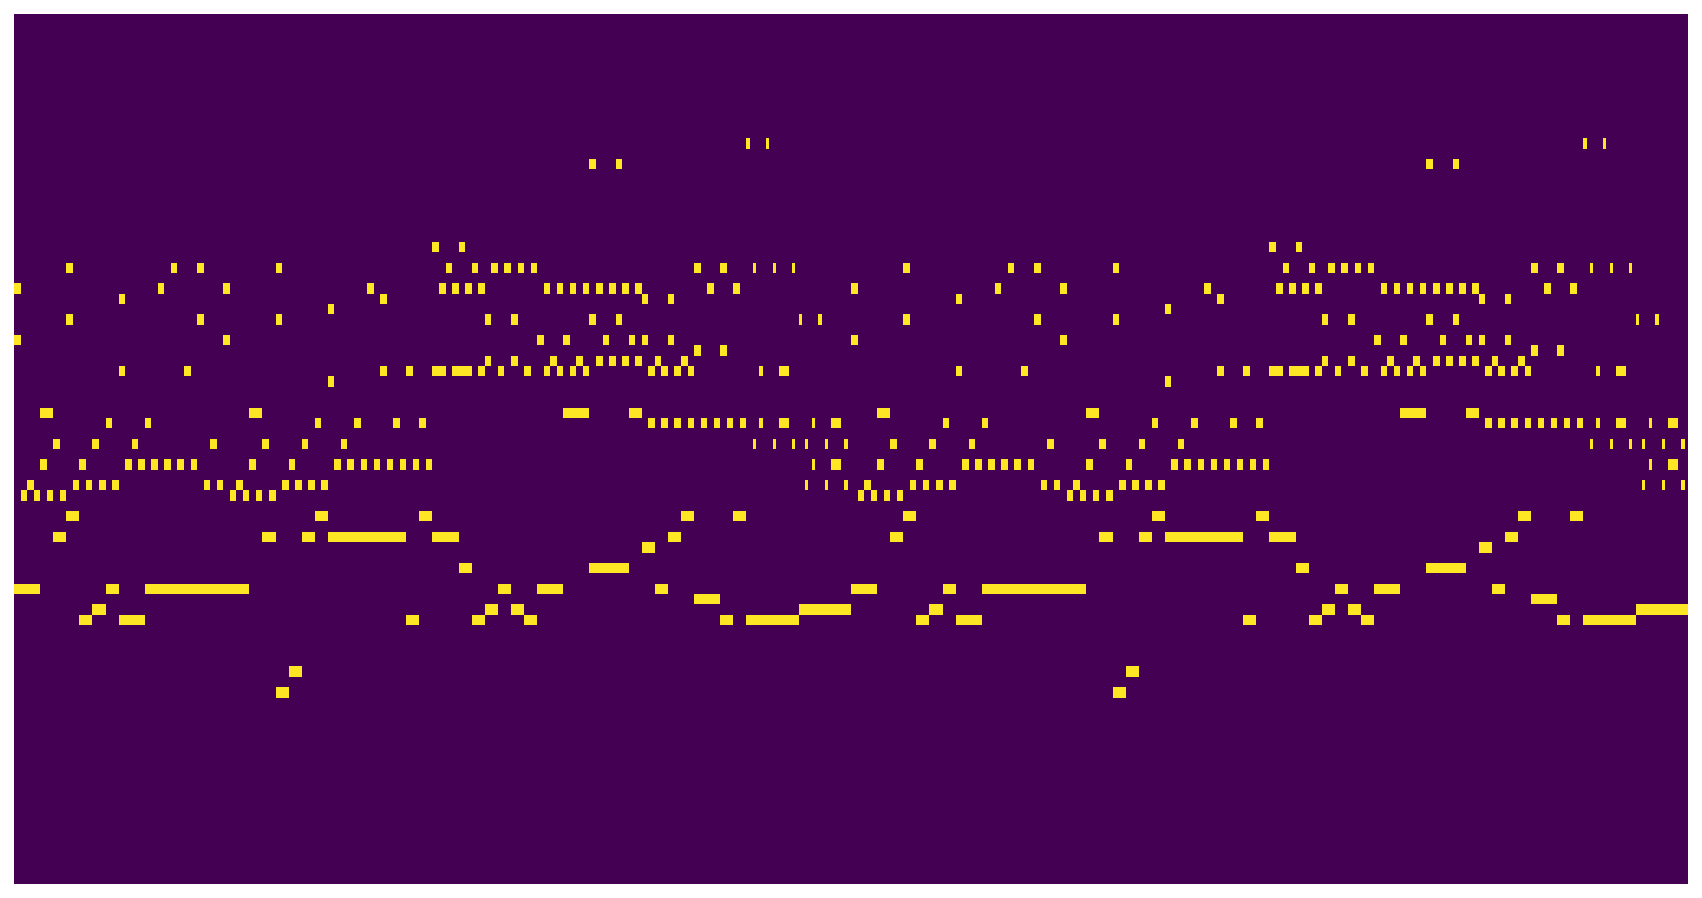

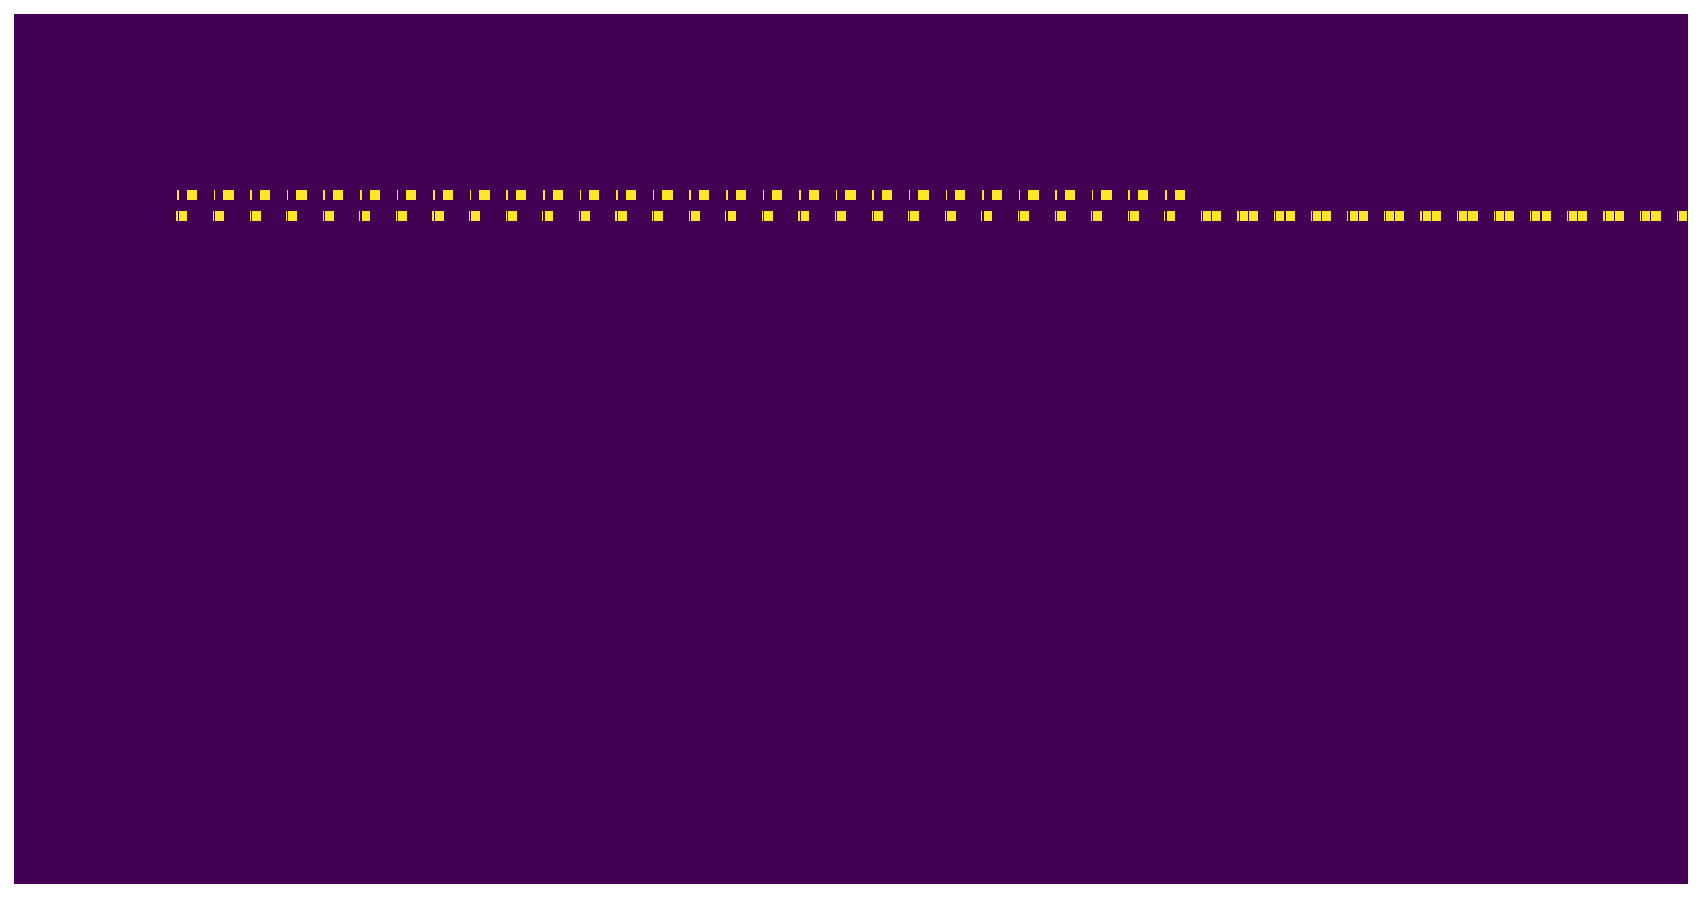

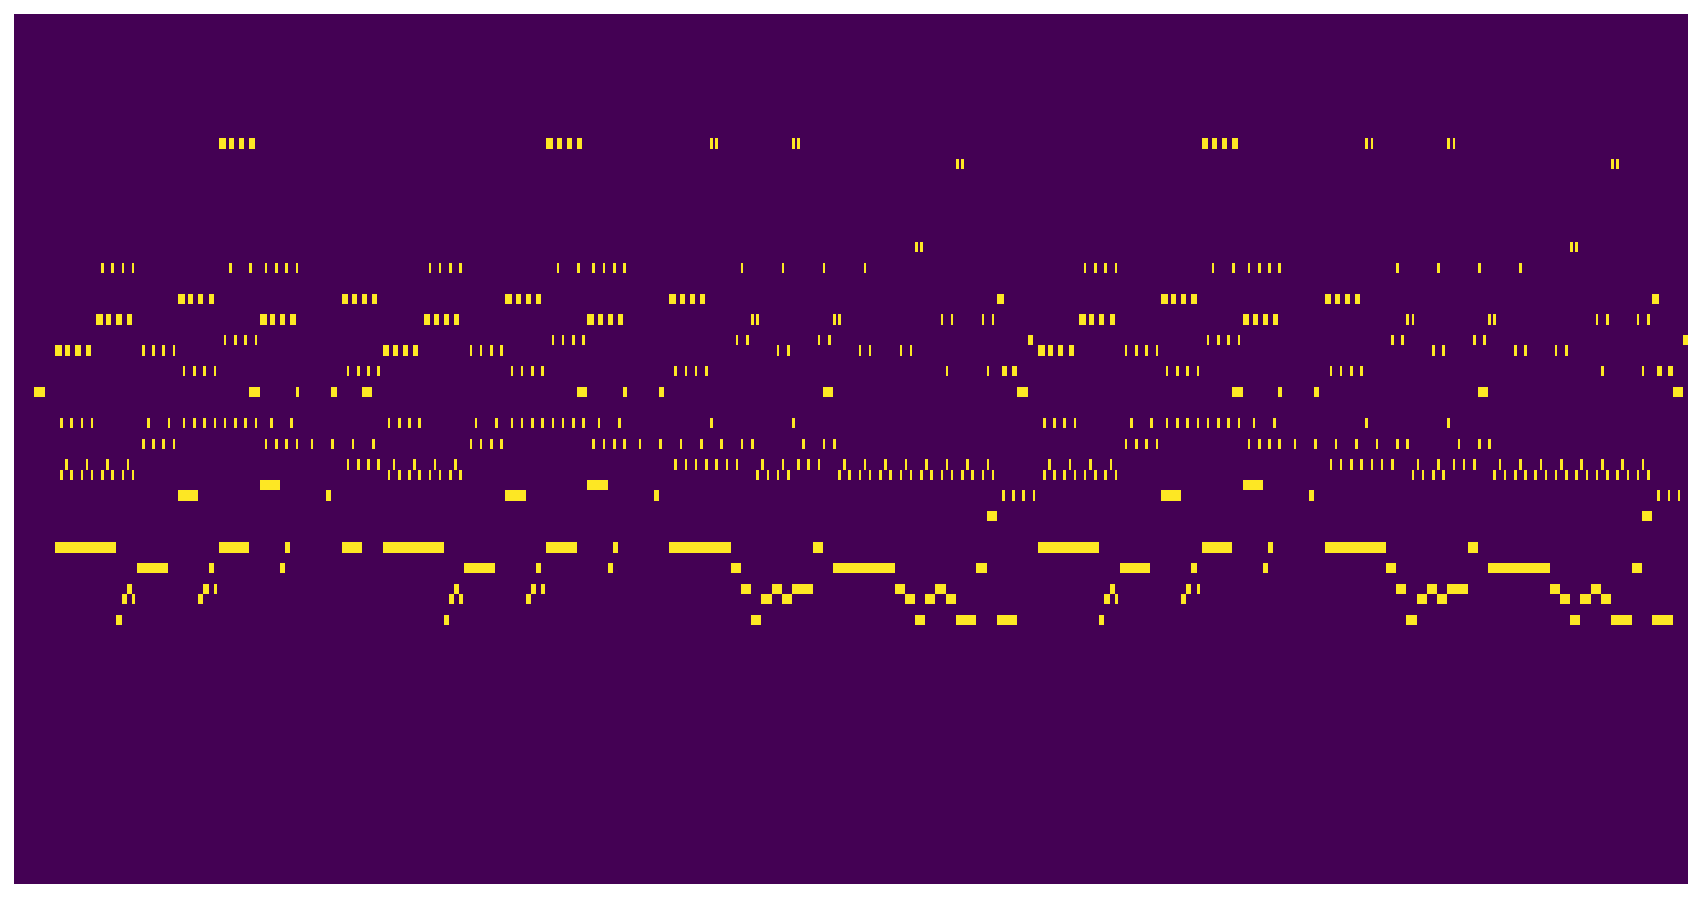

In [312]:
idx_all=np.arange(len(grid_out))
num_plot=10
for i in range(num_plot):
    idx=int(np.random.choice(idx_all,size=1))
    plt.imshow(grid_out[idx],extent=[-10,10,-1,1],aspect='auto')
    plt.axis('off')
    plt.show()

# OK so we have 162 songs for training

Now we just need to do a bit more manipulating to make them into the right shape

(row,column,channel)

In [317]:
print(grid_out[0].shape)
print(grid_out[1].shape)
print(image_width*num_channels)

(84, 3552)
(84, 1536)
192


In [318]:
samples=0
for i in range(len(grid_out)):
    
    images=math.floor(grid_out[i].shape[1]/(image_width))
    samples+=images-(num_channels-1) #the total amount of training data we can have by striding by 1
    
print(samples)

10034


# So for each song

- break the song up into images
- create training data by stacking num_channels images together and then striding by 1

In [319]:
ins=np.zeros((samples,image_height,image_width,num_channels))
print(ins.shape)

sample_idx=-1

for i in range(len(grid_out)):
    
    num_images=math.floor(grid_out[i].shape[1]/(image_width))
    num_samples=num_images-(num_channels-1)
    
    images=np.zeros((image_height,image_width,num_images))
    
    for j in range(num_images):
        
        left_idx=0+j*image_width
        right_idx=image_width+j*image_width
        images[:,:,j]=grid_out[i][:,left_idx:right_idx]
        
    for k in range(num_samples):
        sample_idx+=1
        
        left_idx=k
        right_idx=k+num_channels
    
        ins[sample_idx,:,:,:]=images[:,:,left_idx:right_idx]
        
        
        
        
        
        

(10034, 84, 48, 4)


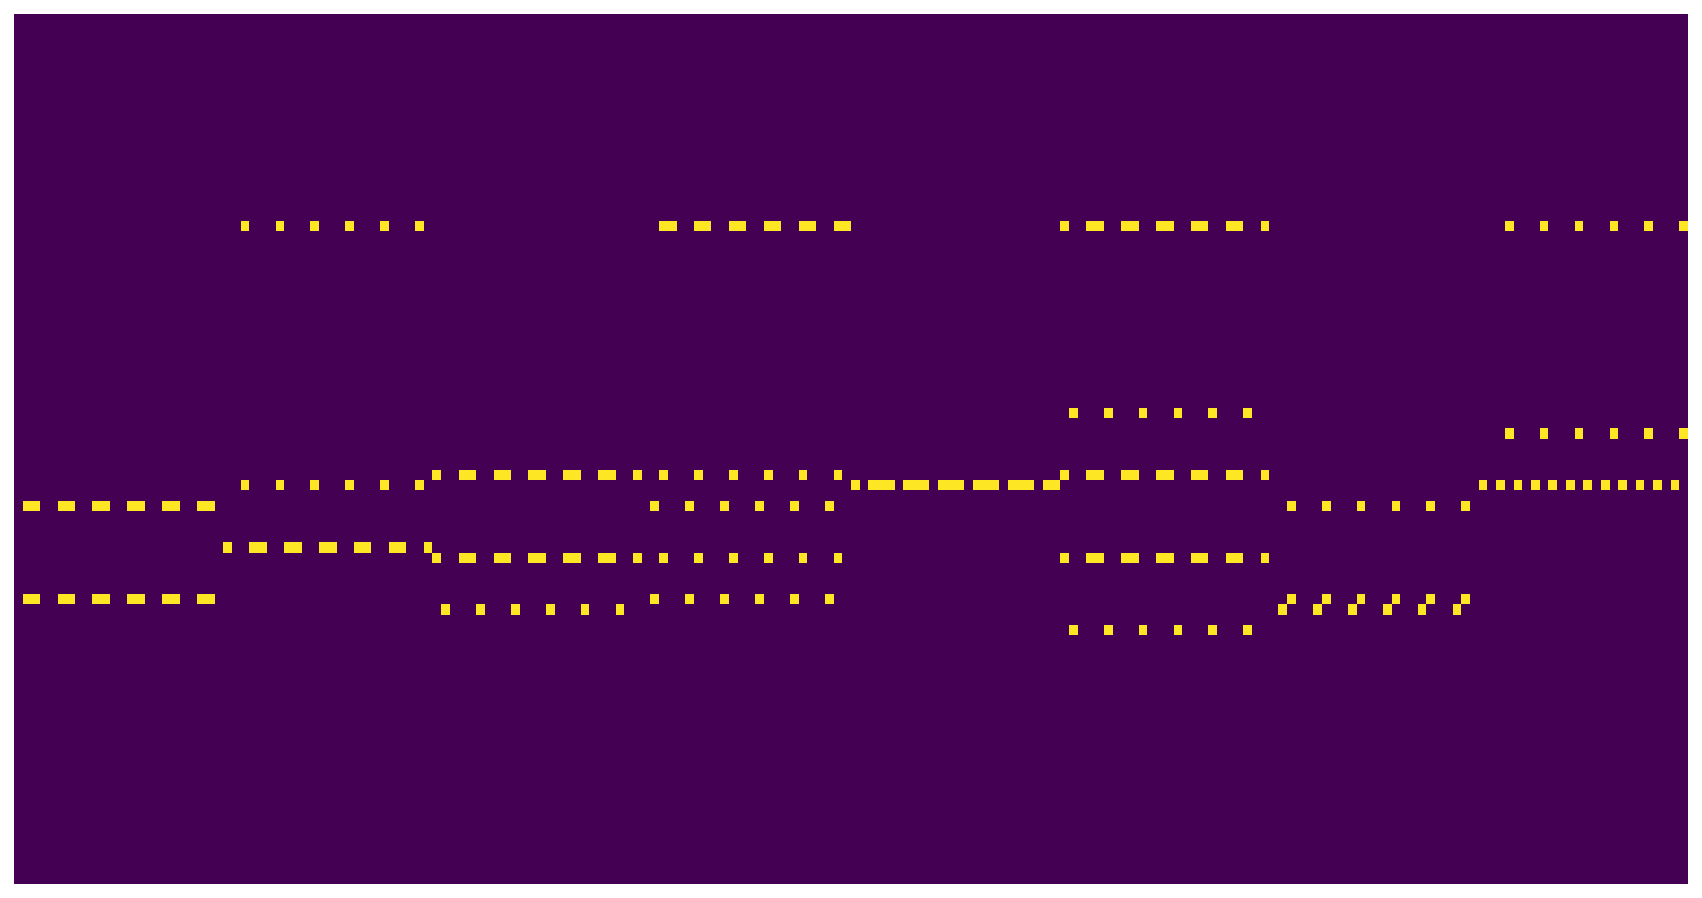

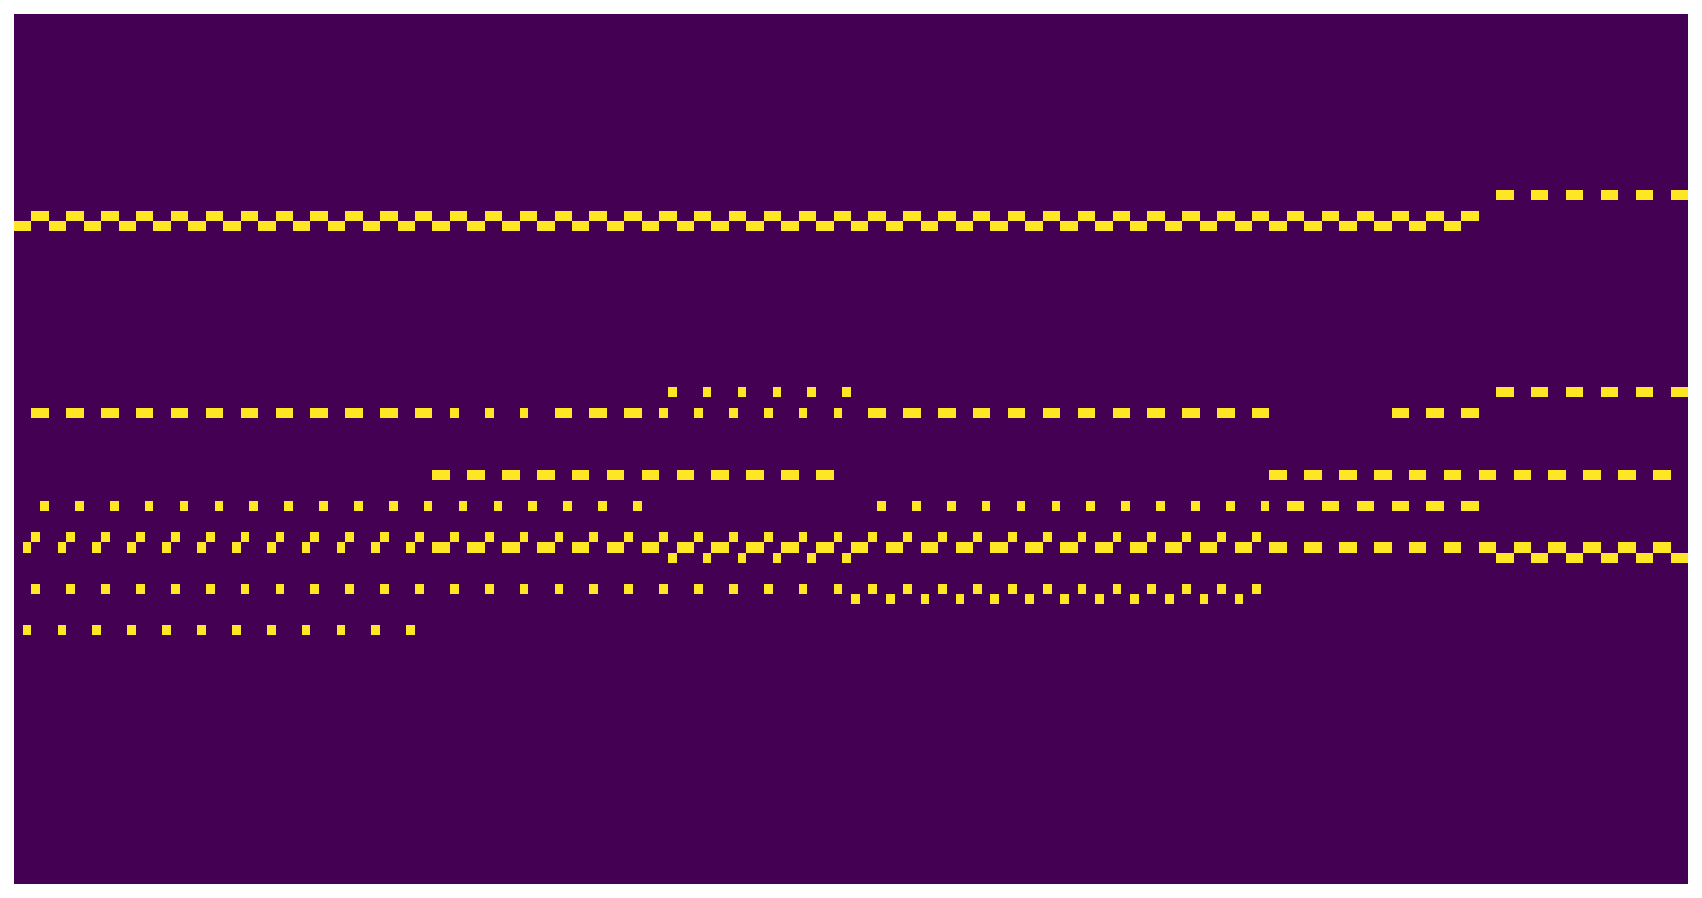

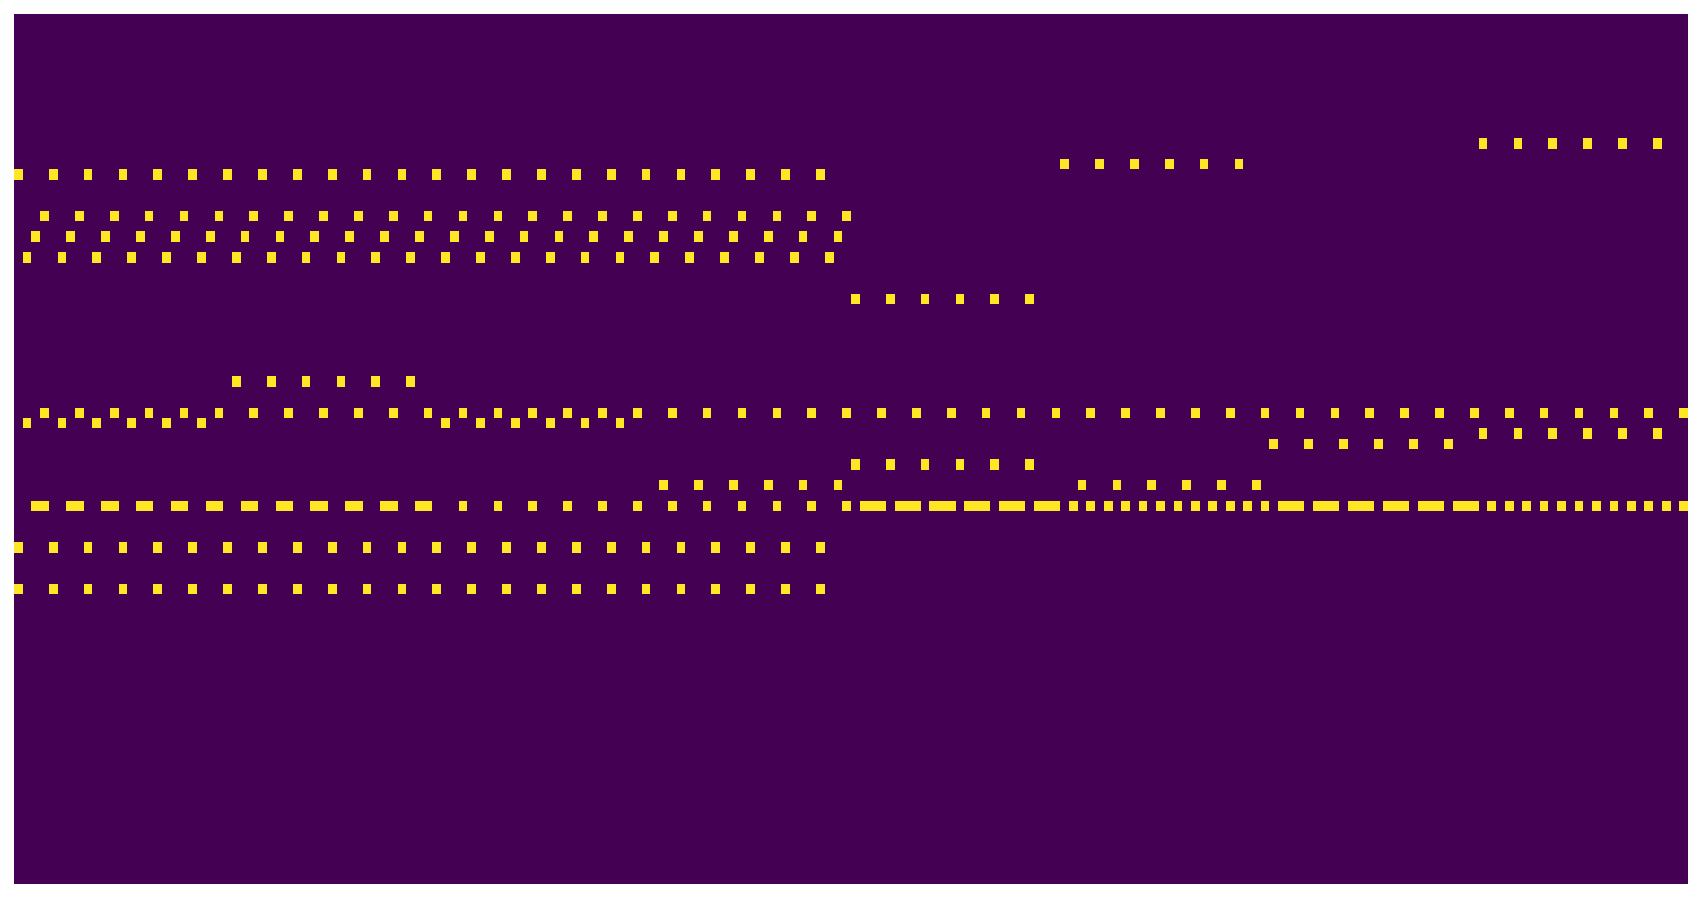

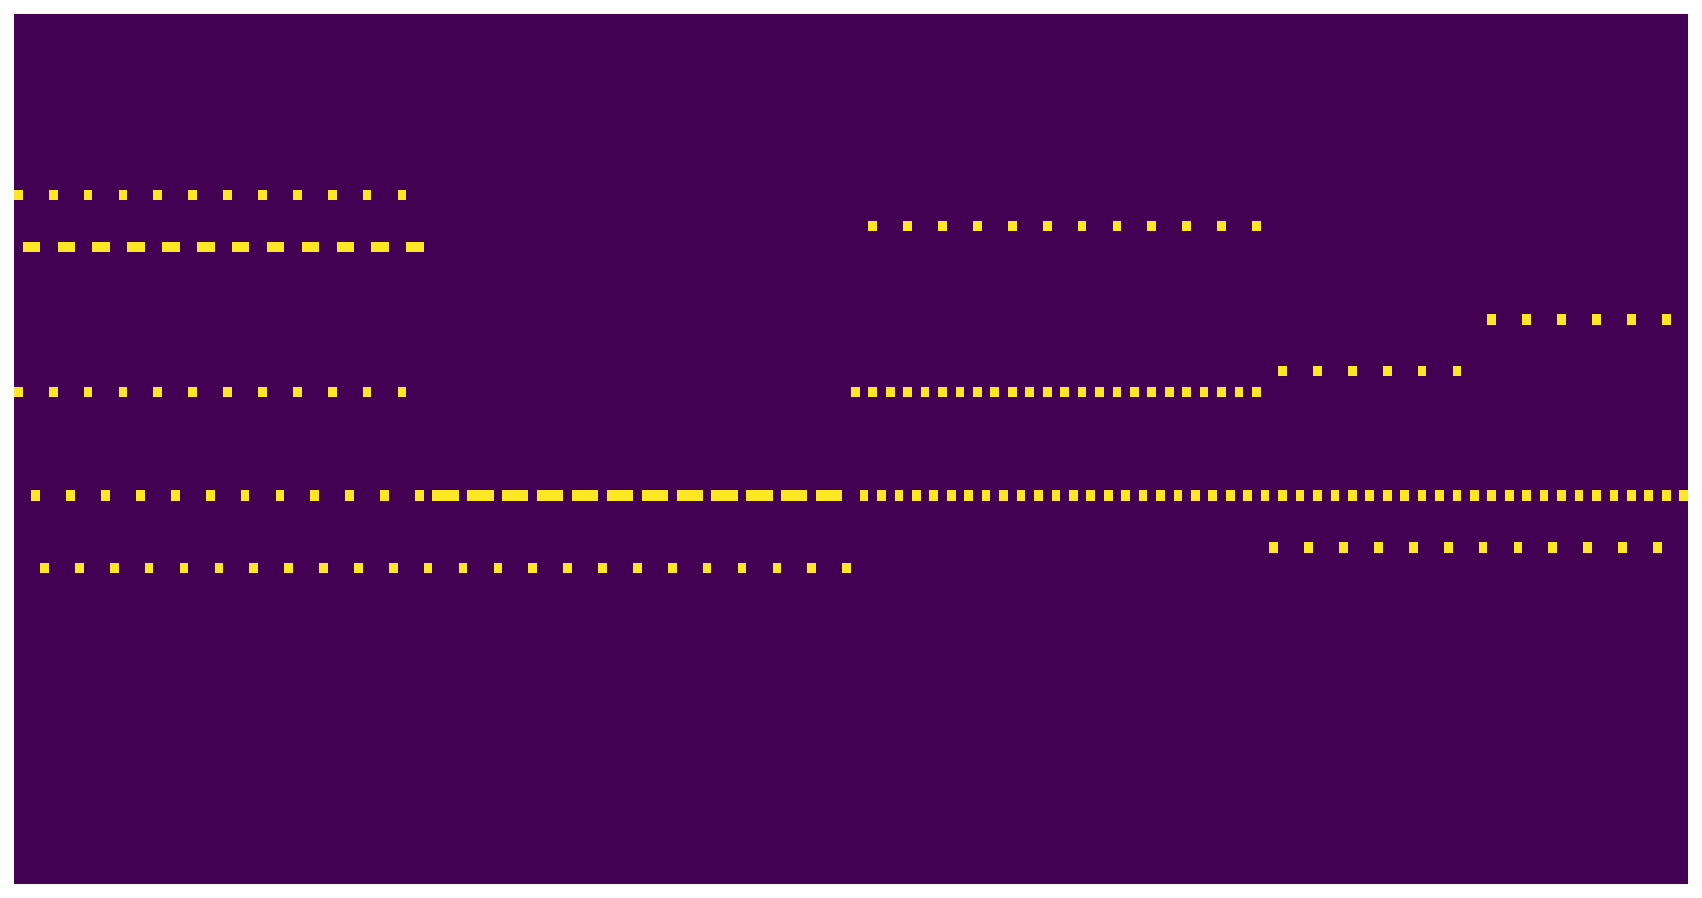

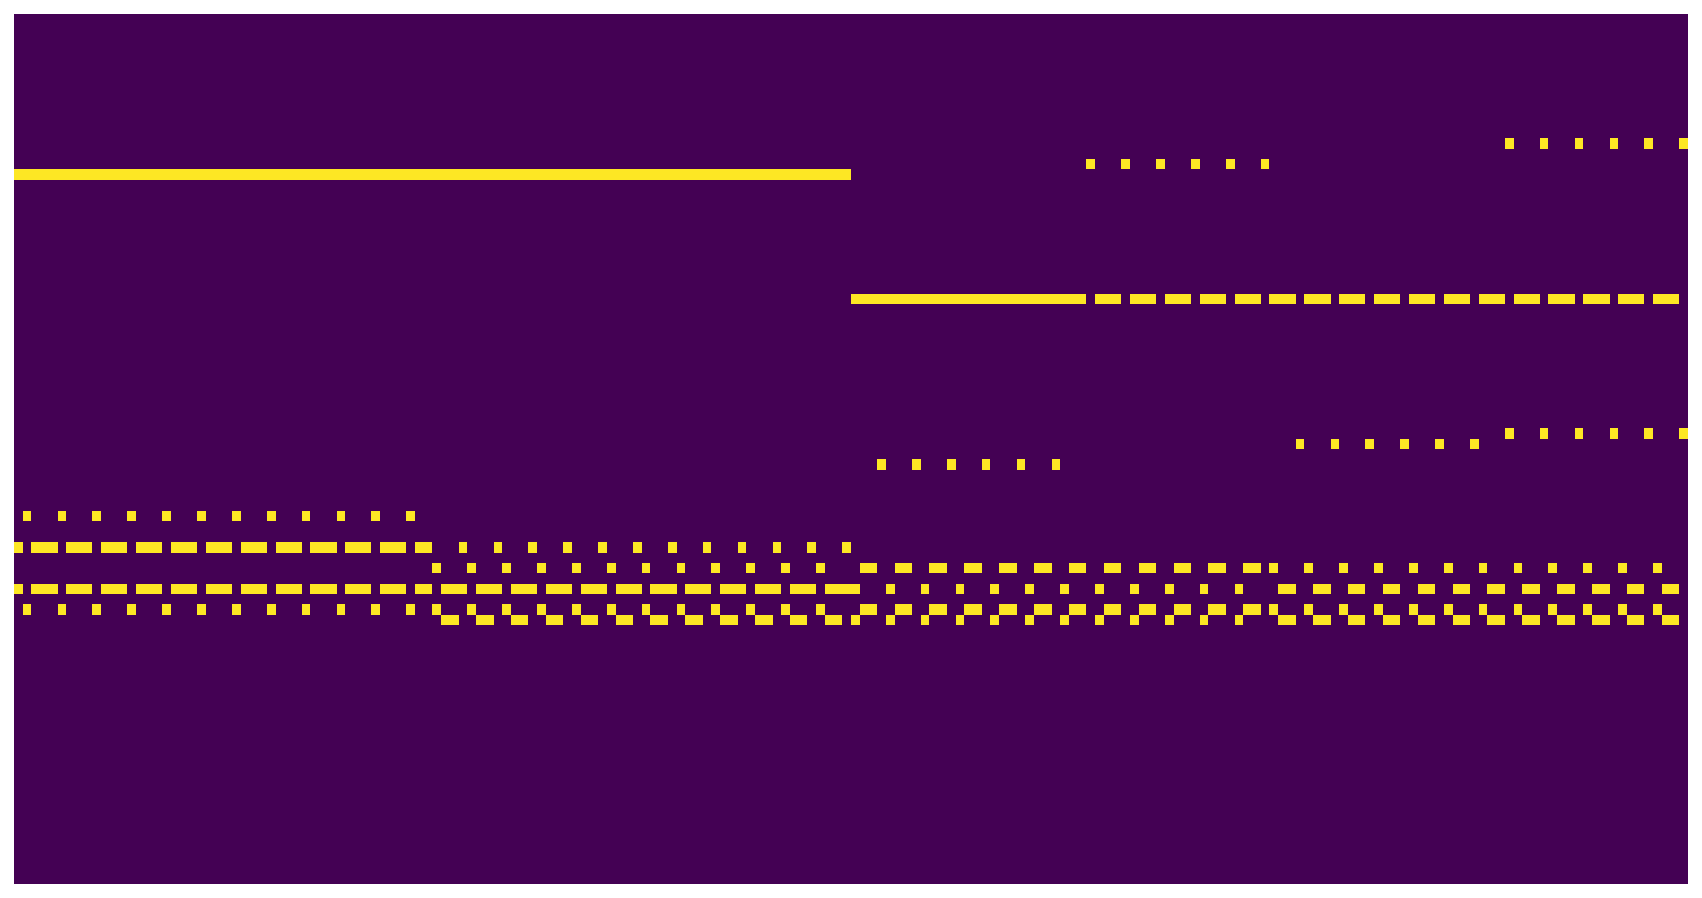

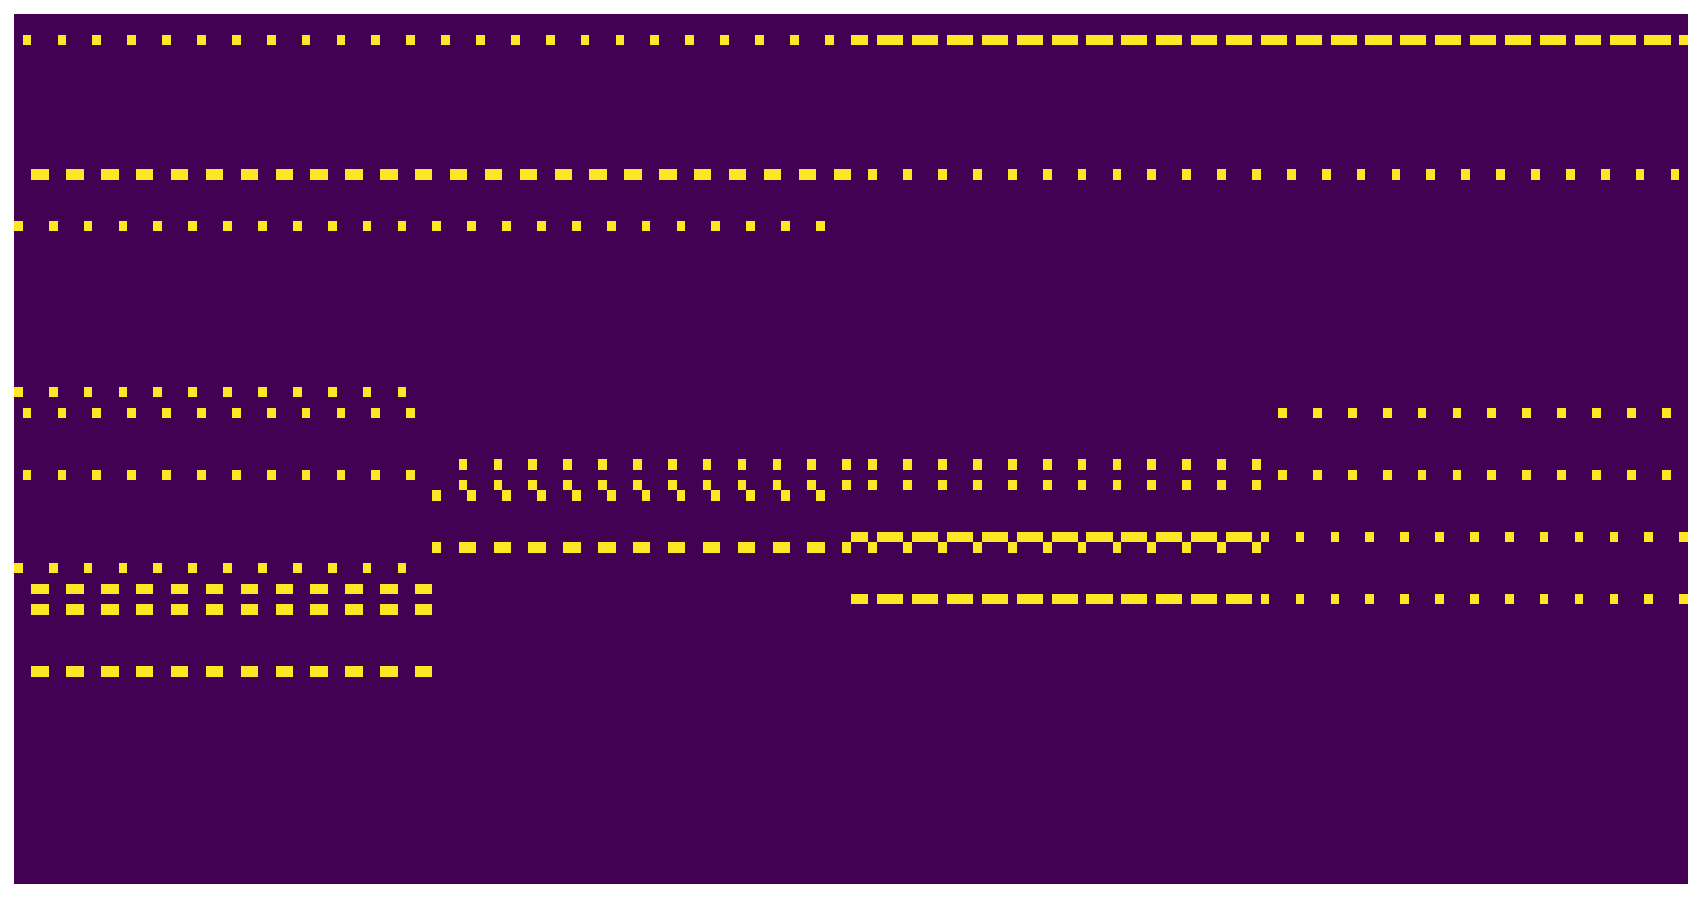

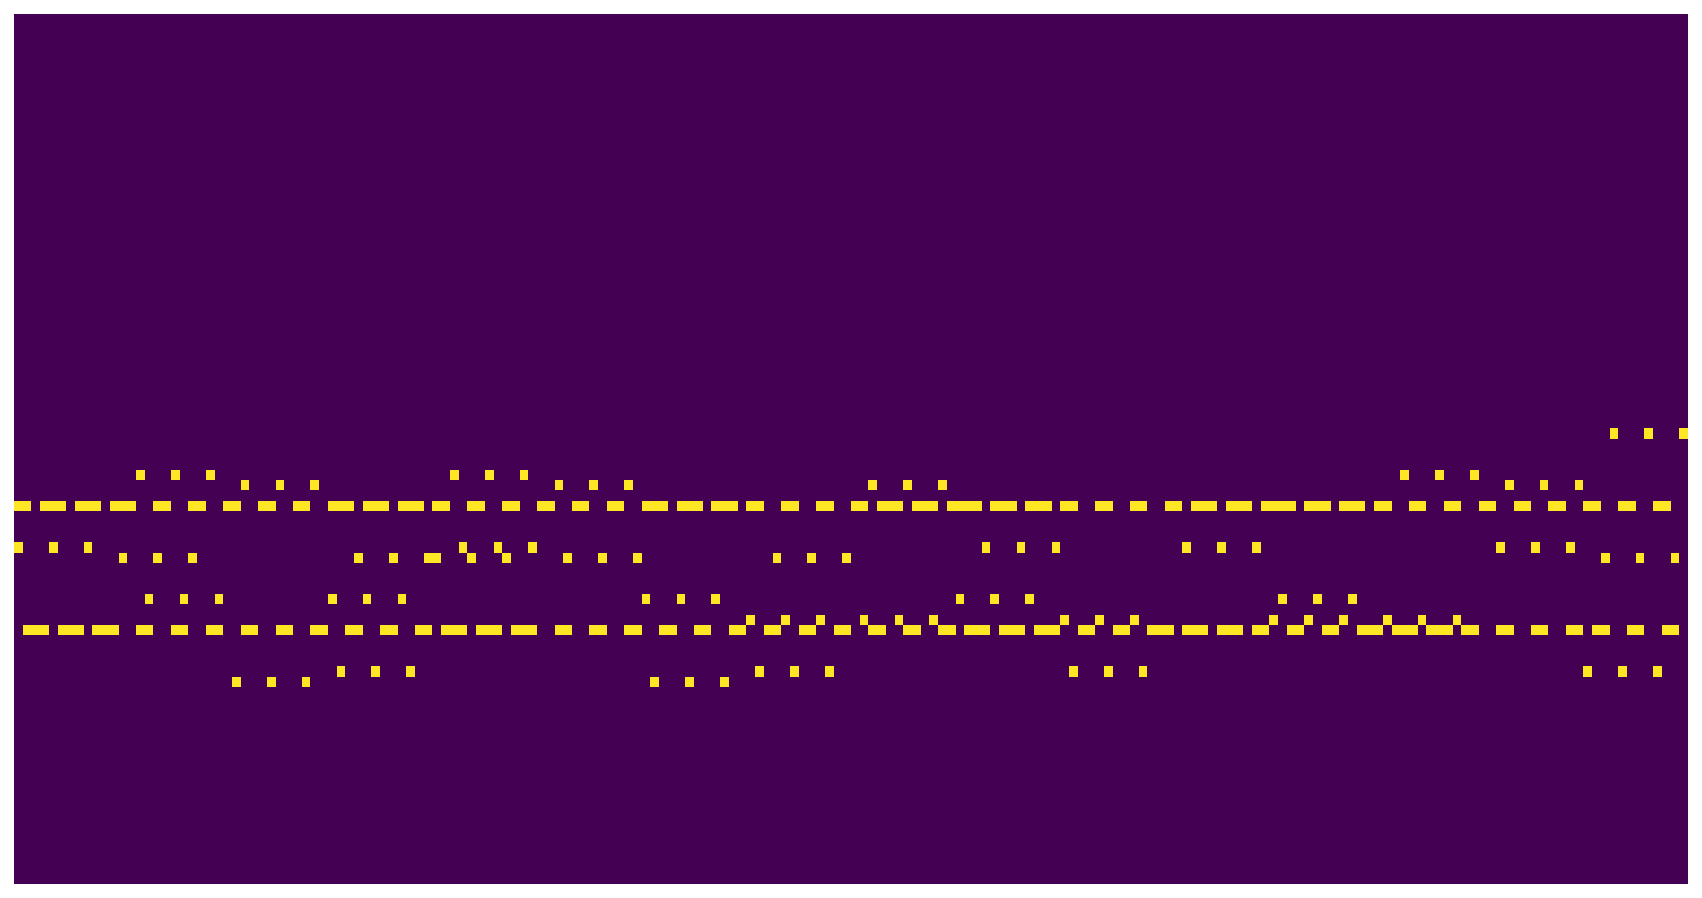

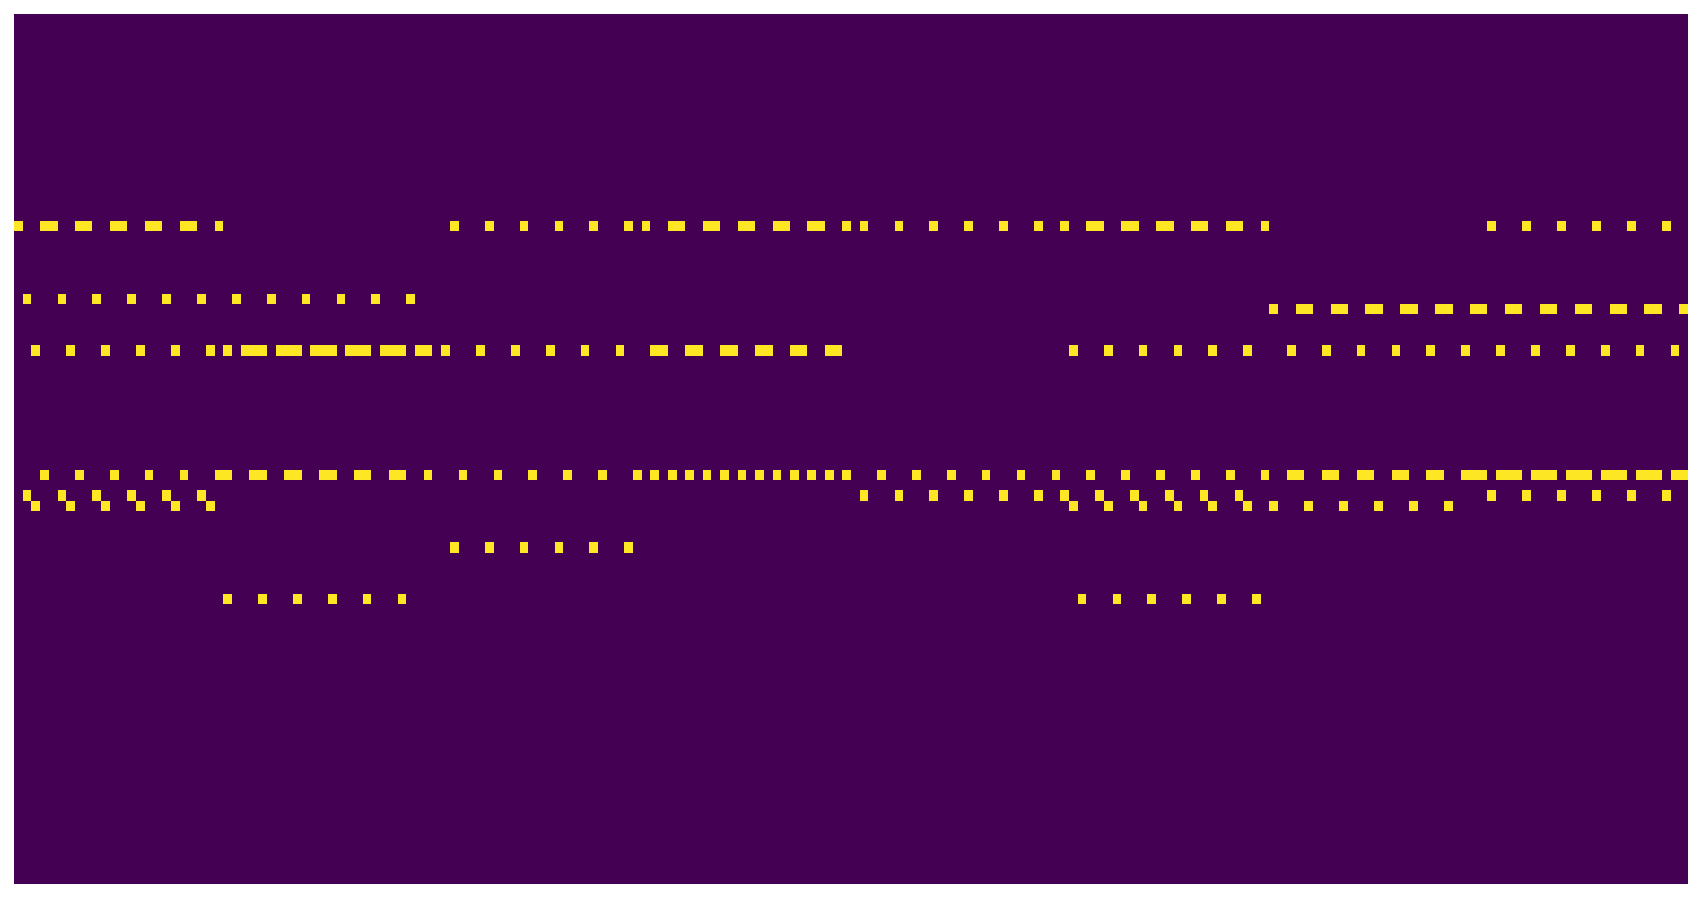

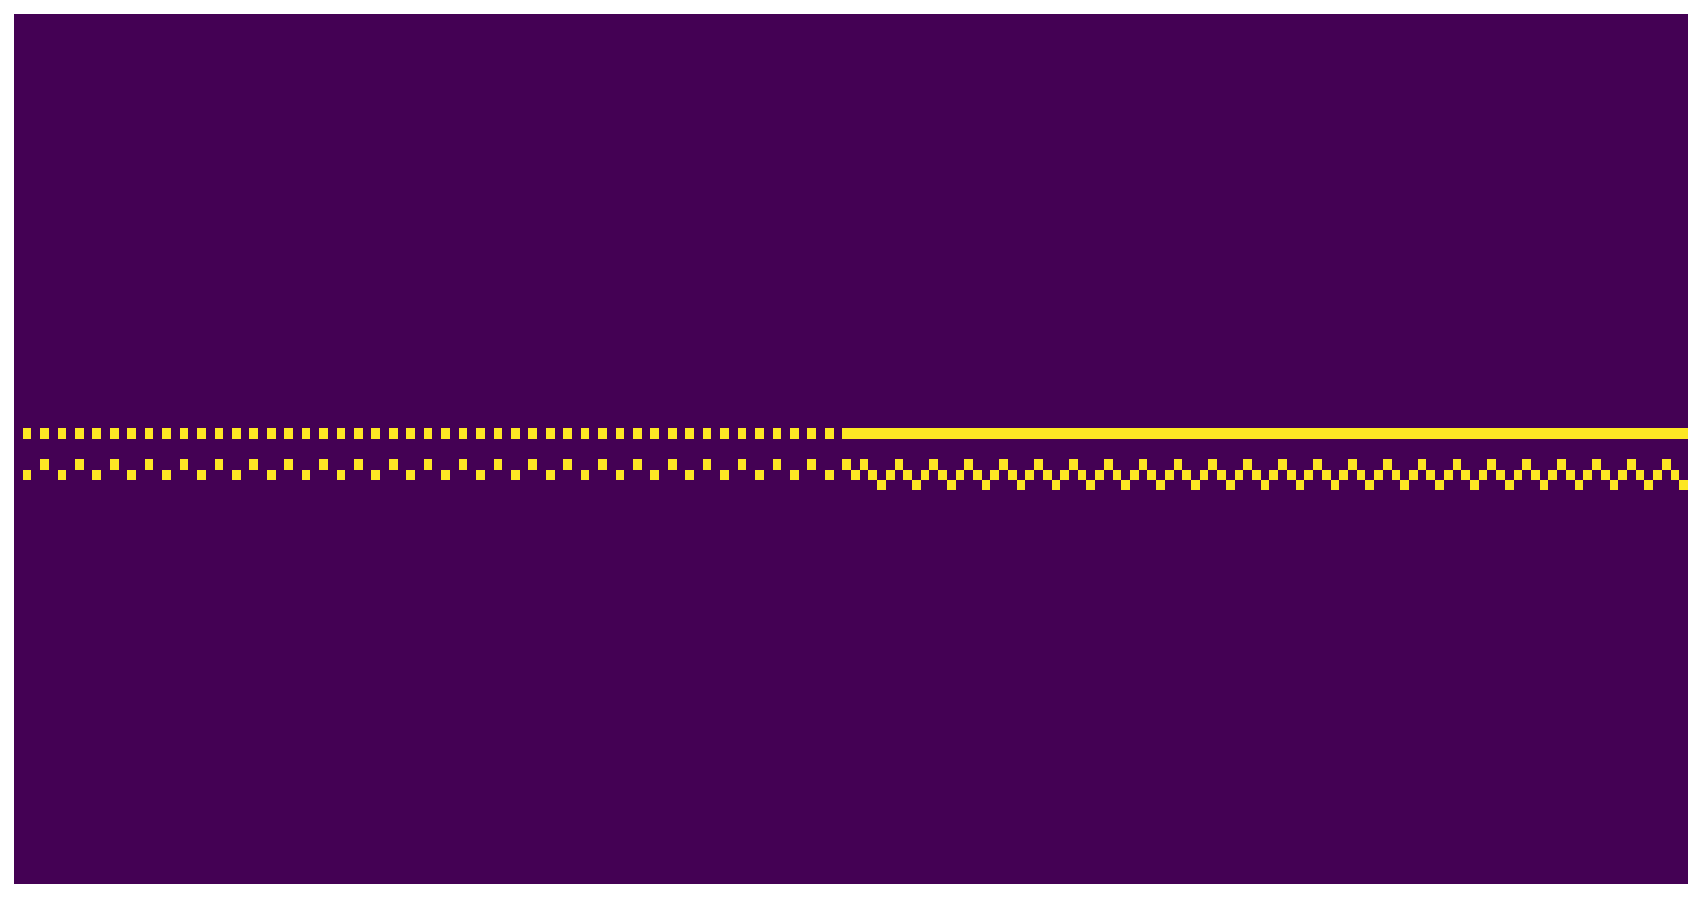

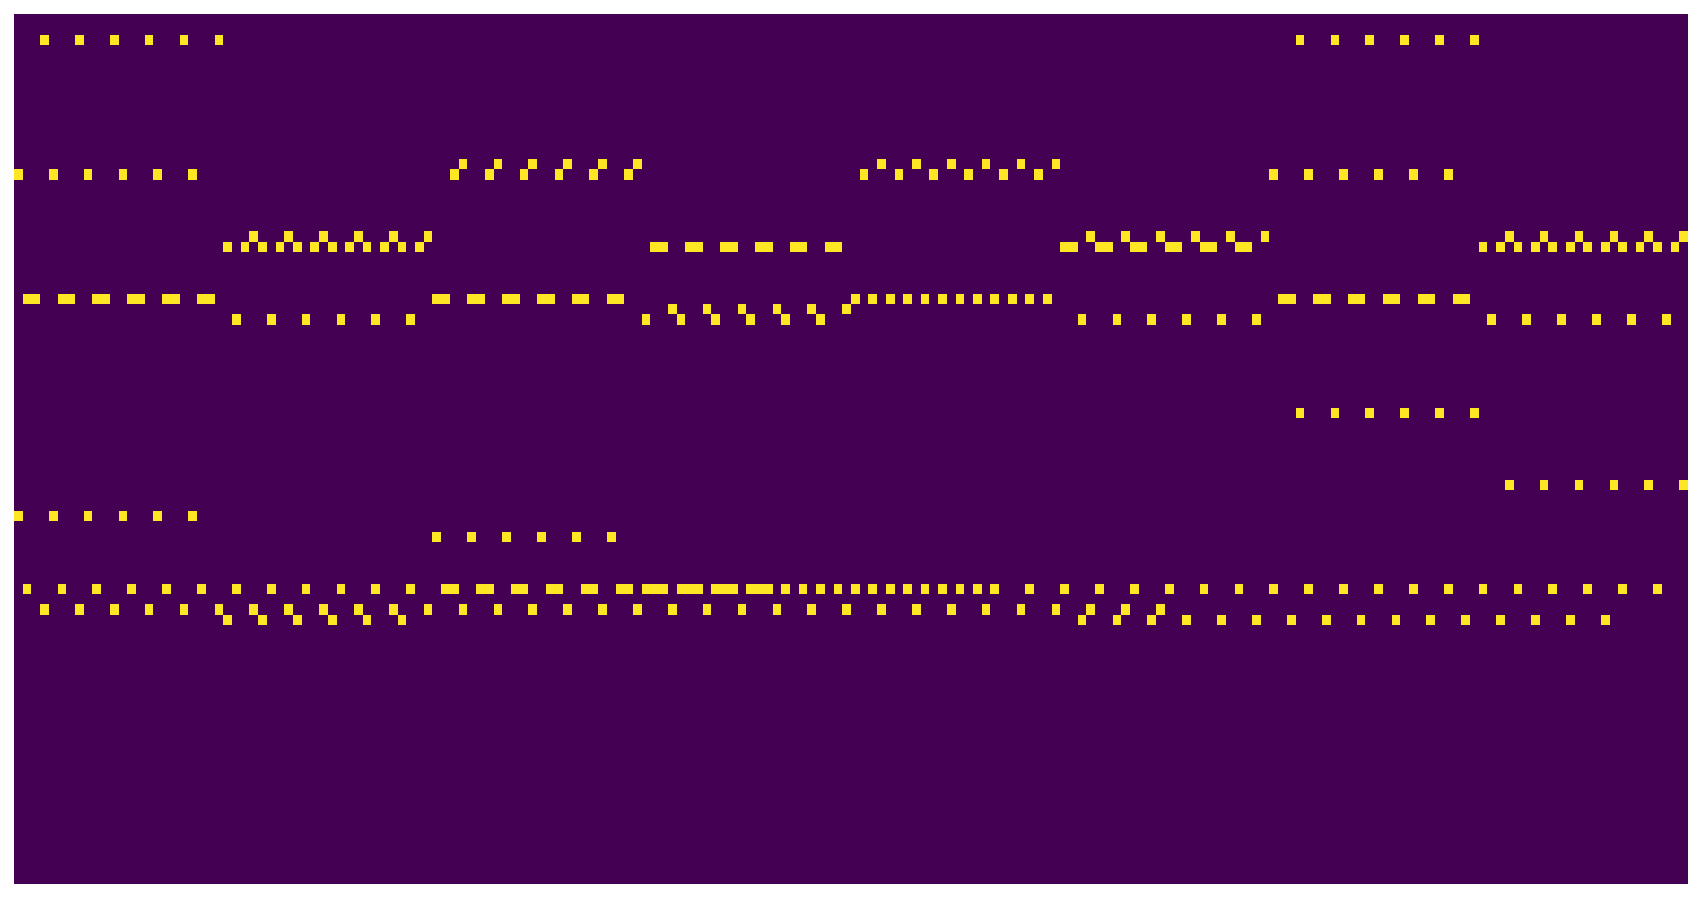

In [322]:
idx_all=np.arange(samples)
num_plot=10
for i in range(num_plot):
    
    idx=np.random.choice(idx_all,size=1)
    
    plt.imshow(ins[idx,:,:,:].reshape(image_height,image_width*num_channels),extent=[-10,10,-1,1],aspect='auto')
    plt.axis('off')
    plt.show()

In [323]:
fp=open("ins_convgan_final_fantasy.pkl",'wb')
pickle.dump(ins,fp)
fp.close()